## This is a test to see if this MAML implementation can be used with stablebaselines3

In [ ]:

#from learn2learn.algorithms.maml import MAML

In [1]:
#Perform imports
import random

import numpy as np
import torch
from torch import optim
from tqdm import tqdm

import gymnasium as gym

from stable_baselines3 import A2C

from stable_baselines3.common.logger import configure


import matplotlib.pyplot as plt


device = 'cpu'# 'cuda' #  #doing cpu as A2C with MlpPolicy (rather than CNNpolicy) in stablebaseline is faster on CPU, and the meta gradinet beign faster on GPU (even if it is) is not *that* much faster - it is about two(ish) times slower overall based on one run each with two meta iterations, so better on cpu in this case
torch.set_default_device(device)

In [ ]:
#Practice robust meta learning of Khazad-Dum

#Hyperparameters
adapt_lr =  7e-4
meta_lr = 0.0005
meta_iterations = 1250
adapt_timesteps = 32*4 
tasks_per_loop = 60
adapt_visualisations = 5


vis_timesteps = meta_iterations//adapt_visualisations #denominator is number of visualisations we want
if vis_timesteps == 0:
    vis_timesteps = 1 

#Make meta-environment
import fabian.envs.khazad_dum_gymn 
env = gym.make("KhazadDum-v1") # can access wrapped env with "env.unwrapped" (e.g. to reset task)
 #^ TODO: make task resetting better than this, maybe have a meta learning wrapper for envs that provides access to these functions in a neater way

#Make meta-policy and meta-optimiser
meta_agent = A2C("MlpPolicy", env, verbose=0, meta_learning=True, learning_rate=adapt_lr, device=device) #we train the meta_agent to do well at adapting to new envs (i.e. meta learning) in our env distribution
meta_opt = optim.Adam(meta_agent.policy.parameters(), lr=meta_lr)


meta_losses = []
meta_rets = []

#Outer meta-learning loop
for meta_it in tqdm(range(meta_iterations)):
    meta_loss = 0
    meta_ret = 0
    #Have agent adapt to tasks one by one
    for t in tqdm(range(tasks_per_loop)):
        env.unwrapped.reset_task() #randomly selects task from environment to reset it to
        
        meta_agent.learn(total_timesteps=adapt_timesteps) #adapt the meta agent to this task

        adaptation_loss, a_rets = meta_agent.run_meta_adaption_and_loss(total_timesteps=100) #sample {total_timesteps} worth of timesteps from task and get loss of adapted agent
                #TODO: this is just for debugging - change stuff so it is just returning loss again soon! andget sepereate func for rets if needed

        meta_loss += adaptation_loss
        meta_ret += a_rets

    #Perform gradient update on meta learning parameters
    meta_loss/=tasks_per_loop #normalise, so that learning rate need not depend on tasks/loop
    meta_ret/=tasks_per_loop
    
    meta_opt.zero_grad()
    meta_loss.backward()
    meta_opt.step()

    #Track meta_training curve
    meta_losses.append(meta_loss.detach().item())
    meta_rets.append(meta_ret.item())
    print(f"Meta loop {meta_it+1}/{meta_iterations} complete, validation loss: {meta_loss.detach().item()}, validation return: {meta_ret}")

    if meta_it % vis_timesteps == 0:
        fig, ax = plt.subplots()
        ax = env.unwrapped.show_state(ax)    
        fig.show()


print(meta_losses)



## success in meta learning KD!

In [ ]:
Below we see successful code for (standard) meta learning of Kazahd-Dum, and the saved parameters and hypoerparameters
    
#TODO: this can be a figure for my diss right?
#TODO: whats up with that learning curve? the loss makes no sense to start with, when i try and minimise it it starts neg and then increases...
#...and then passes zero and continues up and then finally decreases and then becomes pretty stable around zero as desired...
#... while return takes a wierd route too. *IS THIS BECAUSE OF THE CRITIC BEING TRAINED AND THEN META TRAINING OPTIMISIES THE CRITIC
# TO BE A DECENT VALUE FUNCTION OF STATES??? but before then its all unstable and wierd?*

#ask supervisors if i cant work this out myself

100%|██████████| 9/9 [00:01<00:00,  7.65it/s]
C:\Users\fabia\AppData\Local\Temp\ipykernel_15448\3865130541.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


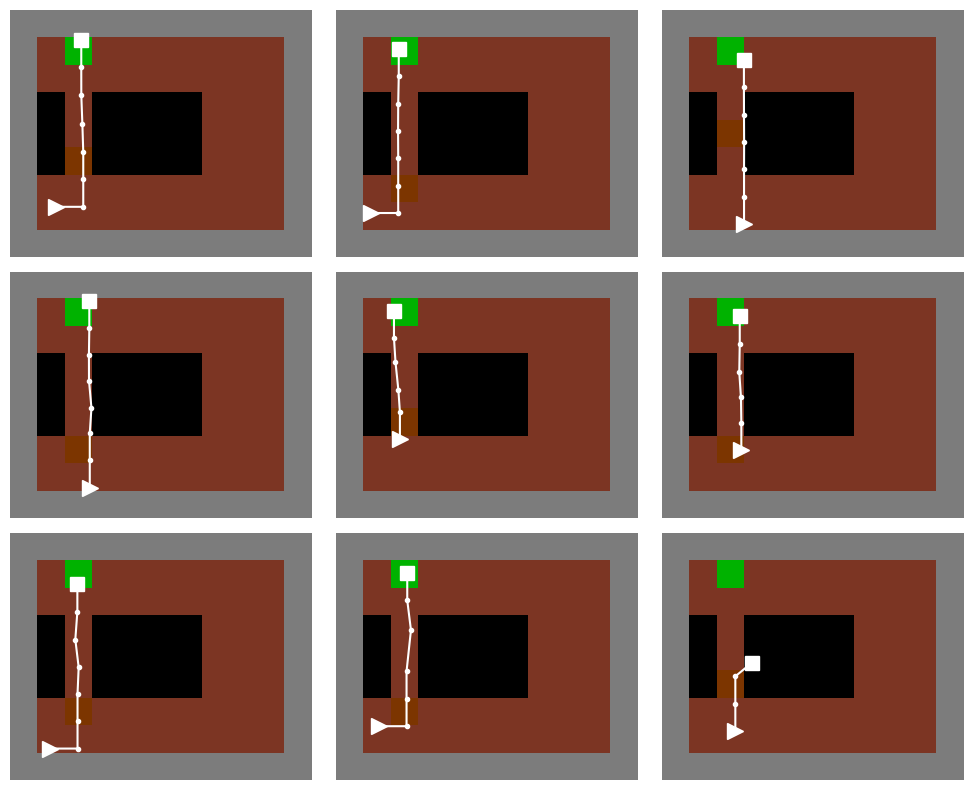

In [38]:
#Seeing it manage in a range of environments
dim = 3
fig, axs = plt.subplots(dim, dim, figsize=(10, 8))

for t in tqdm(range(dim*dim)):
    env.unwrapped.reset_task() #randomly selects task from environment to reset it to
    meta_agent.learn(total_timesteps=adapt_timesteps) #adapt the meta agent to this task
    x = t//dim
    y = t%dim
    axs[x,y] = env.unwrapped.show_state(axs[x,y])    
    axs[x,y].set_axis_off()
plt.tight_layout()
fig.show()


C:\Users\fabia\AppData\Local\Temp\ipykernel_15448\2238904334.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


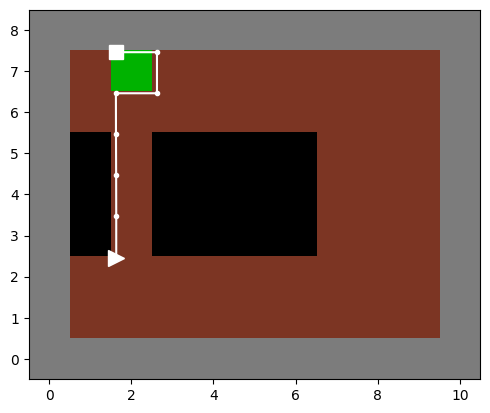

In [6]:
fig, ax = plt.subplots()
ax = env.unwrapped.show_state(ax)    
fig.show()

c:\Users\fabia\anaconda3\envs\learn2learn_newtorch\Lib\site-packages\gymnasium\envs\registration.py:487: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
100%|██████████| 60/60 [00:13<00:00,  4.46it/s]
C:\Users\fabia\AppData\Local\Temp\ipykernel_15448\488294415.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Meta loop 1/1250 complete, validation loss: -0.12223728746175766, validation return: -0.0834522545337677


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 2/1250 complete, validation loss: -0.11822440475225449, validation return: -0.09810736775398254


100%|██████████| 60/60 [00:15<00:00,  3.94it/s]


Meta loop 3/1250 complete, validation loss: -0.12024679034948349, validation return: -0.12191131711006165


100%|██████████| 60/60 [00:16<00:00,  3.53it/s]


Meta loop 4/1250 complete, validation loss: -0.11606548726558685, validation return: -0.1256350427865982


100%|██████████| 60/60 [00:17<00:00,  3.49it/s]


Meta loop 5/1250 complete, validation loss: -0.12058356404304504, validation return: -0.14982075989246368


100%|██████████| 60/60 [00:16<00:00,  3.67it/s]


Meta loop 6/1250 complete, validation loss: -0.12143557518720627, validation return: -0.1837124526500702


100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


Meta loop 7/1250 complete, validation loss: -0.11818400025367737, validation return: -0.19672682881355286


100%|██████████| 60/60 [00:16<00:00,  3.70it/s]


Meta loop 8/1250 complete, validation loss: -0.11680390685796738, validation return: -0.20951628684997559


100%|██████████| 60/60 [00:16<00:00,  3.57it/s]


Meta loop 9/1250 complete, validation loss: -0.11886029690504074, validation return: -0.23378649353981018


100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


Meta loop 10/1250 complete, validation loss: -0.11510400474071503, validation return: -0.2461160272359848


100%|██████████| 60/60 [00:17<00:00,  3.37it/s]


Meta loop 11/1250 complete, validation loss: -0.11820828914642334, validation return: -0.27488115429878235


100%|██████████| 60/60 [00:17<00:00,  3.41it/s]


Meta loop 12/1250 complete, validation loss: -0.11660981923341751, validation return: -0.28640782833099365


100%|██████████| 60/60 [00:18<00:00,  3.32it/s]


Meta loop 13/1250 complete, validation loss: -0.1199723482131958, validation return: -0.3224501311779022


100%|██████████| 60/60 [00:16<00:00,  3.53it/s]


Meta loop 14/1250 complete, validation loss: -0.11047417670488358, validation return: -0.3230198621749878


100%|██████████| 60/60 [00:16<00:00,  3.56it/s]


Meta loop 15/1250 complete, validation loss: -0.1161021888256073, validation return: -0.34599849581718445


100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


Meta loop 16/1250 complete, validation loss: -0.1157727986574173, validation return: -0.3765197992324829


100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


Meta loop 17/1250 complete, validation loss: -0.11102461069822311, validation return: -0.3830093443393707


100%|██████████| 60/60 [00:18<00:00,  3.26it/s]


Meta loop 18/1250 complete, validation loss: -0.11037767678499222, validation return: -0.40632885694503784


100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


Meta loop 19/1250 complete, validation loss: -0.11369495093822479, validation return: -0.44389718770980835


100%|██████████| 60/60 [00:16<00:00,  3.55it/s]


Meta loop 20/1250 complete, validation loss: -0.11159735172986984, validation return: -0.4670618772506714


100%|██████████| 60/60 [00:18<00:00,  3.25it/s]


Meta loop 21/1250 complete, validation loss: -0.10864854604005814, validation return: -0.4652535021305084


100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


Meta loop 22/1250 complete, validation loss: -0.1087530106306076, validation return: -0.46595585346221924


100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


Meta loop 23/1250 complete, validation loss: -0.11172275245189667, validation return: -0.5207033753395081


100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


Meta loop 24/1250 complete, validation loss: -0.10958155244588852, validation return: -0.5478110909461975


100%|██████████| 60/60 [00:13<00:00,  4.55it/s]


Meta loop 25/1250 complete, validation loss: -0.10725276172161102, validation return: -0.5495631098747253


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 26/1250 complete, validation loss: -0.10454616695642471, validation return: -0.5664920210838318


100%|██████████| 60/60 [00:13<00:00,  4.55it/s]


Meta loop 27/1250 complete, validation loss: -0.10543704032897949, validation return: -0.6145287752151489


100%|██████████| 60/60 [00:13<00:00,  4.55it/s]


Meta loop 28/1250 complete, validation loss: -0.1010662093758583, validation return: -0.616490364074707


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 29/1250 complete, validation loss: -0.10445523262023926, validation return: -0.6554809212684631


100%|██████████| 60/60 [00:17<00:00,  3.44it/s]


Meta loop 30/1250 complete, validation loss: -0.1033034399151802, validation return: -0.6539052128791809


100%|██████████| 60/60 [00:16<00:00,  3.72it/s]


Meta loop 31/1250 complete, validation loss: -0.10352294147014618, validation return: -0.688603937625885


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Meta loop 32/1250 complete, validation loss: -0.0985107347369194, validation return: -0.6952124238014221


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 33/1250 complete, validation loss: -0.10274969786405563, validation return: -0.7387209534645081


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 34/1250 complete, validation loss: -0.10094259679317474, validation return: -0.7586142420768738


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 35/1250 complete, validation loss: -0.09807955473661423, validation return: -0.7804411053657532


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 36/1250 complete, validation loss: -0.09559805691242218, validation return: -0.7968886494636536


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 37/1250 complete, validation loss: -0.09301683306694031, validation return: -0.8136242032051086


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 38/1250 complete, validation loss: -0.0939125344157219, validation return: -0.8903712630271912


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 39/1250 complete, validation loss: -0.0891306921839714, validation return: -0.9065975546836853


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 40/1250 complete, validation loss: -0.09070542454719543, validation return: -0.9120428562164307


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 41/1250 complete, validation loss: -0.08432960510253906, validation return: -0.9367080926895142


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 42/1250 complete, validation loss: -0.08112148940563202, validation return: -0.9414732456207275


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 43/1250 complete, validation loss: -0.08555519580841064, validation return: -1.0034763813018799


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 44/1250 complete, validation loss: -0.08473392575979233, validation return: -1.0280485153198242


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 45/1250 complete, validation loss: -0.08470156788825989, validation return: -1.0594383478164673


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 46/1250 complete, validation loss: -0.07469047605991364, validation return: -1.0564290285110474


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 47/1250 complete, validation loss: -0.07547182589769363, validation return: -1.092545747756958


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 48/1250 complete, validation loss: -0.07868178188800812, validation return: -1.1349833011627197


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 49/1250 complete, validation loss: -0.0716661587357521, validation return: -1.1636494398117065


100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Meta loop 50/1250 complete, validation loss: -0.07062574476003647, validation return: -1.1824806928634644


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 51/1250 complete, validation loss: -0.06769965589046478, validation return: -1.2126010656356812


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 52/1250 complete, validation loss: -0.06660103052854538, validation return: -1.2378474473953247


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 53/1250 complete, validation loss: -0.06671151518821716, validation return: -1.2761778831481934


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 54/1250 complete, validation loss: -0.06613317877054214, validation return: -1.2949265241622925


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Meta loop 55/1250 complete, validation loss: -0.06213664636015892, validation return: -1.3630650043487549


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 56/1250 complete, validation loss: -0.05831216275691986, validation return: -1.3661917448043823


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 57/1250 complete, validation loss: -0.05689022317528725, validation return: -1.4027867317199707


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 58/1250 complete, validation loss: -0.05354270711541176, validation return: -1.4113543033599854


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 59/1250 complete, validation loss: -0.054258305579423904, validation return: -1.4393161535263062


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 60/1250 complete, validation loss: -0.05186810344457626, validation return: -1.4881727695465088


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 61/1250 complete, validation loss: -0.05246894806623459, validation return: -1.513607382774353


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 62/1250 complete, validation loss: -0.04322127625346184, validation return: -1.537124752998352


100%|██████████| 60/60 [00:12<00:00,  4.90it/s]


Meta loop 63/1250 complete, validation loss: -0.04944496229290962, validation return: -1.5761170387268066


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 64/1250 complete, validation loss: -0.04613159969449043, validation return: -1.6265778541564941


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 65/1250 complete, validation loss: -0.041667621582746506, validation return: -1.6369831562042236


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 66/1250 complete, validation loss: -0.04458896815776825, validation return: -1.6725775003433228


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 67/1250 complete, validation loss: -0.03812587261199951, validation return: -1.6712390184402466


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 68/1250 complete, validation loss: -0.035397980362176895, validation return: -1.7039427757263184


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 69/1250 complete, validation loss: -0.036999642848968506, validation return: -1.7325694561004639


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 70/1250 complete, validation loss: -0.035602208226919174, validation return: -1.7930092811584473


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 71/1250 complete, validation loss: -0.033445410430431366, validation return: -1.8006291389465332


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 72/1250 complete, validation loss: -0.02861679717898369, validation return: -1.8222745656967163


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 73/1250 complete, validation loss: -0.0260752122849226, validation return: -1.851343035697937


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 74/1250 complete, validation loss: -0.026326706632971764, validation return: -1.866188406944275


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 75/1250 complete, validation loss: -0.028622178360819817, validation return: -1.9096988439559937


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 76/1250 complete, validation loss: -0.027702881023287773, validation return: -1.9366555213928223


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 77/1250 complete, validation loss: -0.02296041138470173, validation return: -1.9318124055862427


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 78/1250 complete, validation loss: -0.026326864957809448, validation return: -1.9749605655670166


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 79/1250 complete, validation loss: -0.022935589775443077, validation return: -2.0168540477752686


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 80/1250 complete, validation loss: -0.025349752977490425, validation return: -2.0252926349639893


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 81/1250 complete, validation loss: -0.026439301669597626, validation return: -2.0618512630462646


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 82/1250 complete, validation loss: -0.02385864593088627, validation return: -2.0577104091644287


100%|██████████| 60/60 [00:12<00:00,  4.92it/s]


Meta loop 83/1250 complete, validation loss: -0.02616240456700325, validation return: -2.089937686920166


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 84/1250 complete, validation loss: -0.02198689617216587, validation return: -2.1173293590545654


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 85/1250 complete, validation loss: -0.018282005563378334, validation return: -2.1216416358947754


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 86/1250 complete, validation loss: -0.020098106935620308, validation return: -2.15411114692688


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 87/1250 complete, validation loss: -0.016152184456586838, validation return: -2.1685423851013184


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 88/1250 complete, validation loss: -0.014518809504806995, validation return: -2.1836297512054443


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 89/1250 complete, validation loss: -0.01666674204170704, validation return: -2.2096846103668213


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 90/1250 complete, validation loss: -0.020782535895705223, validation return: -2.2311363220214844


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 91/1250 complete, validation loss: -0.021087858825922012, validation return: -2.2599668502807617


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 92/1250 complete, validation loss: -0.020427975803613663, validation return: -2.28250789642334


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 93/1250 complete, validation loss: -0.01348950993269682, validation return: -2.2863779067993164


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 94/1250 complete, validation loss: -0.014971910044550896, validation return: -2.308582067489624


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 95/1250 complete, validation loss: -0.018220627680420876, validation return: -2.331900119781494


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 96/1250 complete, validation loss: -0.013975346460938454, validation return: -2.3425986766815186


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 97/1250 complete, validation loss: -0.005293873138725758, validation return: -2.35591197013855


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 98/1250 complete, validation loss: -0.012319104745984077, validation return: -2.3776497840881348


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 99/1250 complete, validation loss: -0.014158026315271854, validation return: -2.396013021469116


100%|██████████| 60/60 [00:14<00:00,  4.08it/s]


Meta loop 100/1250 complete, validation loss: -0.007521435618400574, validation return: -2.4186689853668213


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 101/1250 complete, validation loss: -0.013301962986588478, validation return: -2.439154863357544


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 102/1250 complete, validation loss: -0.007822191342711449, validation return: -2.422076940536499


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 103/1250 complete, validation loss: -0.011699246242642403, validation return: -2.4863150119781494


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 104/1250 complete, validation loss: -0.004655301105231047, validation return: -2.4668989181518555


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 105/1250 complete, validation loss: -0.007264305837452412, validation return: -2.4916229248046875


100%|██████████| 60/60 [00:15<00:00,  3.94it/s]


Meta loop 106/1250 complete, validation loss: -0.0026650947984308004, validation return: -2.493513822555542


100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Meta loop 107/1250 complete, validation loss: -0.006331734824925661, validation return: -2.5167362689971924


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 108/1250 complete, validation loss: -0.0028176114428788424, validation return: -2.5112569332122803


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 109/1250 complete, validation loss: -0.002298948122188449, validation return: -2.529853105545044


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 110/1250 complete, validation loss: -0.0038484325632452965, validation return: -2.5251567363739014


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 111/1250 complete, validation loss: -0.0018617304740473628, validation return: -2.527513027191162


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 112/1250 complete, validation loss: -0.0026897003408521414, validation return: -2.5396714210510254


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 113/1250 complete, validation loss: 0.004942696075886488, validation return: -2.5050394535064697


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 114/1250 complete, validation loss: 0.0014567561447620392, validation return: -2.5213332176208496


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 115/1250 complete, validation loss: -0.004677454475313425, validation return: -2.5275368690490723


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 116/1250 complete, validation loss: 0.0013631253968924284, validation return: -2.5059926509857178


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 117/1250 complete, validation loss: -0.0032080886885523796, validation return: -2.5092008113861084


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 118/1250 complete, validation loss: 0.002140257740393281, validation return: -2.4773037433624268


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 119/1250 complete, validation loss: 0.006292459089308977, validation return: -2.4485554695129395


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Meta loop 120/1250 complete, validation loss: -0.003586787963286042, validation return: -2.444178342819214


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 121/1250 complete, validation loss: -0.0015625929227098823, validation return: -2.4298112392425537


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 122/1250 complete, validation loss: -0.01039357390254736, validation return: -2.4632182121276855


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 123/1250 complete, validation loss: -0.0032755068968981504, validation return: -2.454094171524048


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 124/1250 complete, validation loss: -0.0022830364760011435, validation return: -2.37957763671875


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 125/1250 complete, validation loss: -0.008794525638222694, validation return: -2.4244585037231445


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 126/1250 complete, validation loss: -0.007972503080964088, validation return: -2.3884618282318115


100%|██████████| 60/60 [00:15<00:00,  4.00it/s]


Meta loop 127/1250 complete, validation loss: -0.008930599316954613, validation return: -2.374019145965576


100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


Meta loop 128/1250 complete, validation loss: -0.01293326448649168, validation return: -2.3903181552886963


100%|██████████| 60/60 [00:15<00:00,  3.94it/s]


Meta loop 129/1250 complete, validation loss: -0.0156188840046525, validation return: -2.3945388793945312


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 130/1250 complete, validation loss: -0.010093793272972107, validation return: -2.3496856689453125


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 131/1250 complete, validation loss: -0.01386950258165598, validation return: -2.3815159797668457


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 132/1250 complete, validation loss: -0.01263540331274271, validation return: -2.3805837631225586


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 133/1250 complete, validation loss: -0.014046503230929375, validation return: -2.3900532722473145


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 134/1250 complete, validation loss: -0.018019206821918488, validation return: -2.390730381011963


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 135/1250 complete, validation loss: -0.015267313458025455, validation return: -2.3957228660583496


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 136/1250 complete, validation loss: -0.01792479120194912, validation return: -2.403144598007202


100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


Meta loop 137/1250 complete, validation loss: -0.020141664892435074, validation return: -2.4259915351867676


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 138/1250 complete, validation loss: -0.01504767220467329, validation return: -2.430972099304199


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 139/1250 complete, validation loss: -0.016150306910276413, validation return: -2.4628281593322754


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 140/1250 complete, validation loss: -0.019457465037703514, validation return: -2.5078585147857666


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 141/1250 complete, validation loss: -0.01787617616355419, validation return: -2.5061533451080322


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 142/1250 complete, validation loss: -0.01711096800863743, validation return: -2.5330655574798584


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 143/1250 complete, validation loss: -0.01711748167872429, validation return: -2.5618631839752197


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 144/1250 complete, validation loss: -0.016795825213193893, validation return: -2.6111762523651123


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 145/1250 complete, validation loss: -0.013887584209442139, validation return: -2.6293792724609375


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 146/1250 complete, validation loss: -0.010860721580684185, validation return: -2.663349151611328


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]


Meta loop 147/1250 complete, validation loss: -0.012061519548296928, validation return: -2.709451913833618


100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


Meta loop 148/1250 complete, validation loss: -0.012206735089421272, validation return: -2.7507283687591553


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 149/1250 complete, validation loss: -0.010457712225615978, validation return: -2.77585506439209


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]


Meta loop 150/1250 complete, validation loss: -0.009756898507475853, validation return: -2.813253879547119


100%|██████████| 60/60 [00:15<00:00,  3.94it/s]


Meta loop 151/1250 complete, validation loss: -0.007573929149657488, validation return: -2.8375799655914307


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 152/1250 complete, validation loss: -0.0027415903750807047, validation return: -2.8694872856140137


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 153/1250 complete, validation loss: -0.002626473782584071, validation return: -2.8981292247772217


100%|██████████| 60/60 [00:12<00:00,  4.84it/s]


Meta loop 154/1250 complete, validation loss: -0.004449072293937206, validation return: -2.936131715774536


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 155/1250 complete, validation loss: -0.0032470098230987787, validation return: -2.9570233821868896


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 156/1250 complete, validation loss: -0.001639708993025124, validation return: -2.994921922683716


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 157/1250 complete, validation loss: 0.0019840311724692583, validation return: -2.9977571964263916


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 158/1250 complete, validation loss: 0.002866808557882905, validation return: -3.018930673599243


100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


Meta loop 159/1250 complete, validation loss: 0.0064225648529827595, validation return: -3.028470754623413


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 160/1250 complete, validation loss: 0.0029164901934564114, validation return: -3.0388877391815186


100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


Meta loop 161/1250 complete, validation loss: 0.005560286343097687, validation return: -3.052284002304077


100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


Meta loop 162/1250 complete, validation loss: 0.006039106752723455, validation return: -3.047989845275879


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 163/1250 complete, validation loss: 0.004461782984435558, validation return: -3.0550129413604736


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 164/1250 complete, validation loss: 0.006439735647290945, validation return: -3.049405813217163


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 165/1250 complete, validation loss: 0.012662423774600029, validation return: -3.0339953899383545


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 166/1250 complete, validation loss: 0.007728887256234884, validation return: -3.036015510559082


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 167/1250 complete, validation loss: 0.007951895706355572, validation return: -3.024555206298828


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 168/1250 complete, validation loss: 0.007965950295329094, validation return: -3.0176684856414795


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 169/1250 complete, validation loss: 0.010541480965912342, validation return: -2.9996728897094727


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 170/1250 complete, validation loss: 0.013443228788673878, validation return: -2.9832420349121094


100%|██████████| 60/60 [00:15<00:00,  4.00it/s]


Meta loop 171/1250 complete, validation loss: 0.012382027693092823, validation return: -2.9726054668426514


100%|██████████| 60/60 [00:15<00:00,  3.94it/s]


Meta loop 172/1250 complete, validation loss: 0.008384245447814465, validation return: -2.9640042781829834


100%|██████████| 60/60 [00:15<00:00,  3.97it/s]


Meta loop 173/1250 complete, validation loss: 0.00567730562761426, validation return: -2.9508590698242188


100%|██████████| 60/60 [00:15<00:00,  3.99it/s]


Meta loop 174/1250 complete, validation loss: 0.006267038639634848, validation return: -2.9376893043518066


100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


Meta loop 175/1250 complete, validation loss: 0.008646978996694088, validation return: -2.9123661518096924


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 176/1250 complete, validation loss: 0.012863163836300373, validation return: -2.887211561203003


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 177/1250 complete, validation loss: 0.011870610527694225, validation return: -2.8637712001800537


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 178/1250 complete, validation loss: 0.0061621470376849174, validation return: -2.8578314781188965


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 179/1250 complete, validation loss: 0.006496152374893427, validation return: -2.8317763805389404


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 180/1250 complete, validation loss: 0.001719846623018384, validation return: -2.8308634757995605


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 181/1250 complete, validation loss: 0.010381566360592842, validation return: -2.7986018657684326


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 182/1250 complete, validation loss: 0.0070906952023506165, validation return: -2.774101734161377


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 183/1250 complete, validation loss: 0.011298797093331814, validation return: -2.748725414276123


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 184/1250 complete, validation loss: 0.01840529404580593, validation return: -2.7278554439544678


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 185/1250 complete, validation loss: 0.009124387986958027, validation return: -2.696023464202881


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 186/1250 complete, validation loss: 0.01538836769759655, validation return: -2.676442861557007


100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


Meta loop 187/1250 complete, validation loss: 0.017715808004140854, validation return: -2.6456234455108643


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 188/1250 complete, validation loss: 0.01812005415558815, validation return: -2.601296901702881


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 189/1250 complete, validation loss: 0.01962963491678238, validation return: -2.5679121017456055


100%|██████████| 60/60 [00:14<00:00,  4.25it/s]


Meta loop 190/1250 complete, validation loss: 0.02029380574822426, validation return: -2.5254275798797607


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 191/1250 complete, validation loss: 0.030020007863640785, validation return: -2.4640631675720215


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 192/1250 complete, validation loss: 0.037463486194610596, validation return: -2.410723924636841


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 193/1250 complete, validation loss: 0.02917560003697872, validation return: -2.367342233657837


100%|██████████| 60/60 [00:15<00:00,  4.00it/s]


Meta loop 194/1250 complete, validation loss: 0.02693207748234272, validation return: -2.322218894958496


100%|██████████| 60/60 [00:15<00:00,  3.90it/s]


Meta loop 195/1250 complete, validation loss: 0.04252372682094574, validation return: -2.2248599529266357


100%|██████████| 60/60 [00:14<00:00,  4.01it/s]


Meta loop 196/1250 complete, validation loss: 0.04275784641504288, validation return: -2.1982529163360596


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 197/1250 complete, validation loss: 0.03066161833703518, validation return: -2.1584370136260986


100%|██████████| 60/60 [00:14<00:00,  4.01it/s]


Meta loop 198/1250 complete, validation loss: 0.04372198507189751, validation return: -2.0518109798431396


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 199/1250 complete, validation loss: 0.03622489050030708, validation return: -2.0140721797943115


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 200/1250 complete, validation loss: 0.036820121109485626, validation return: -1.9149614572525024


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 201/1250 complete, validation loss: 0.048235323280096054, validation return: -1.8350164890289307


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 202/1250 complete, validation loss: 0.04901755973696709, validation return: -1.7751939296722412


100%|██████████| 60/60 [00:13<00:00,  4.53it/s]


Meta loop 203/1250 complete, validation loss: 0.046714577823877335, validation return: -1.7413439750671387


100%|██████████| 60/60 [00:13<00:00,  4.55it/s]


Meta loop 204/1250 complete, validation loss: 0.0483764223754406, validation return: -1.6322840452194214


100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Meta loop 205/1250 complete, validation loss: 0.05140332132577896, validation return: -1.5379198789596558


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 206/1250 complete, validation loss: 0.05439731106162071, validation return: -1.466371774673462


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 207/1250 complete, validation loss: 0.04892838001251221, validation return: -1.4269077777862549


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 208/1250 complete, validation loss: 0.047213852405548096, validation return: -1.35814368724823


100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


Meta loop 209/1250 complete, validation loss: 0.0611049048602581, validation return: -1.2780063152313232


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 210/1250 complete, validation loss: 0.05147760733962059, validation return: -1.2048794031143188


100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


Meta loop 211/1250 complete, validation loss: 0.049028344452381134, validation return: -1.1400033235549927


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 212/1250 complete, validation loss: 0.04676663875579834, validation return: -1.1071640253067017


100%|██████████| 60/60 [00:14<00:00,  4.26it/s]


Meta loop 213/1250 complete, validation loss: 0.04447045549750328, validation return: -1.0391089916229248


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 214/1250 complete, validation loss: 0.03667866811156273, validation return: -1.0209039449691772


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 215/1250 complete, validation loss: 0.04131532087922096, validation return: -0.949809193611145


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 216/1250 complete, validation loss: 0.04274860396981239, validation return: -0.8468518853187561


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 217/1250 complete, validation loss: 0.043584879487752914, validation return: -0.7975254058837891


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 218/1250 complete, validation loss: 0.03069731406867504, validation return: -0.8103708028793335


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 219/1250 complete, validation loss: 0.03528729826211929, validation return: -0.7035518288612366


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 220/1250 complete, validation loss: 0.027090882882475853, validation return: -0.6961519718170166


100%|██████████| 60/60 [00:15<00:00,  3.86it/s]


Meta loop 221/1250 complete, validation loss: 0.0339648500084877, validation return: -0.6072387099266052


100%|██████████| 60/60 [00:12<00:00,  4.88it/s]


Meta loop 222/1250 complete, validation loss: 0.033514950424432755, validation return: -0.5432373881340027


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 223/1250 complete, validation loss: 0.028659451752901077, validation return: -0.48572471737861633


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 224/1250 complete, validation loss: 0.02315072901546955, validation return: -0.4939875900745392


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 225/1250 complete, validation loss: 0.025496801361441612, validation return: -0.423574298620224


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 226/1250 complete, validation loss: 0.021977940574288368, validation return: -0.3726309537887573


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 227/1250 complete, validation loss: 0.016977377235889435, validation return: -0.36302319169044495


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 228/1250 complete, validation loss: 0.01680939644575119, validation return: -0.27703458070755005


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 229/1250 complete, validation loss: 0.018317658454179764, validation return: -0.24089762568473816


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 230/1250 complete, validation loss: 0.008382252417504787, validation return: -0.272330105304718


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 231/1250 complete, validation loss: 0.009962661191821098, validation return: -0.17611055076122284


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 232/1250 complete, validation loss: 0.010325311683118343, validation return: -0.17388078570365906


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 233/1250 complete, validation loss: 0.006518832873553038, validation return: -0.1687707155942917


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 234/1250 complete, validation loss: 0.006598969921469688, validation return: -0.09899532049894333


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 235/1250 complete, validation loss: 0.004270987585186958, validation return: -0.05444014444947243


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 236/1250 complete, validation loss: 0.0006902810418978333, validation return: -0.028068847954273224


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 237/1250 complete, validation loss: 0.0003216018667444587, validation return: -0.037487566471099854


100%|██████████| 60/60 [00:15<00:00,  3.97it/s]


Meta loop 238/1250 complete, validation loss: -0.0036698919720947742, validation return: 0.006114137824624777


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 239/1250 complete, validation loss: -0.005524166859686375, validation return: 0.013869219459593296


100%|██████████| 60/60 [00:15<00:00,  3.96it/s]


Meta loop 240/1250 complete, validation loss: -0.007403080351650715, validation return: 0.031018594279885292


100%|██████████| 60/60 [00:14<00:00,  4.00it/s]


Meta loop 241/1250 complete, validation loss: -0.012163070030510426, validation return: 0.05268905311822891


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 242/1250 complete, validation loss: -0.01396182831376791, validation return: 0.05702189728617668


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 243/1250 complete, validation loss: -0.010582643561065197, validation return: 0.08785606175661087


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 244/1250 complete, validation loss: -0.018152933567762375, validation return: 0.08266564458608627


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 245/1250 complete, validation loss: -0.021350573748350143, validation return: 0.0883551612496376


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 246/1250 complete, validation loss: -0.020213965326547623, validation return: 0.1113404929637909


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 247/1250 complete, validation loss: -0.020167868584394455, validation return: 0.10726173222064972


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 248/1250 complete, validation loss: -0.023975802585482597, validation return: 0.11083295941352844


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 249/1250 complete, validation loss: -0.023718466982245445, validation return: 0.11961591243743896


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 250/1250 complete, validation loss: -0.0266227088868618, validation return: 0.11103782057762146


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 251/1250 complete, validation loss: -0.025839710608124733, validation return: 0.10839031636714935


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 252/1250 complete, validation loss: -0.026202231645584106, validation return: 0.1130281612277031


100%|██████████| 60/60 [00:13<00:00,  4.55it/s]


Meta loop 253/1250 complete, validation loss: -0.024564197286963463, validation return: 0.11035708338022232


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 254/1250 complete, validation loss: -0.02477920986711979, validation return: 0.11199541389942169


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 255/1250 complete, validation loss: -0.026793938130140305, validation return: 0.09596862643957138


100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


Meta loop 256/1250 complete, validation loss: -0.022754507139325142, validation return: 0.08641479909420013


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 257/1250 complete, validation loss: -0.023806320503354073, validation return: 0.07255062460899353


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 258/1250 complete, validation loss: -0.02288314886391163, validation return: 0.060377493500709534


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 259/1250 complete, validation loss: -0.024671923369169235, validation return: 0.044047001749277115


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 260/1250 complete, validation loss: -0.021628836169838905, validation return: 0.02205359935760498


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 261/1250 complete, validation loss: -0.020606504753232002, validation return: 0.00415964238345623


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 262/1250 complete, validation loss: -0.019784243777394295, validation return: -0.01854035072028637


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]


Meta loop 263/1250 complete, validation loss: -0.020473796874284744, validation return: -0.042702071368694305


100%|██████████| 60/60 [00:15<00:00,  3.94it/s]


Meta loop 264/1250 complete, validation loss: -0.020563850179314613, validation return: -0.07148697972297668


100%|██████████| 60/60 [00:15<00:00,  3.96it/s]


Meta loop 265/1250 complete, validation loss: -0.017751647159457207, validation return: -0.08245328068733215


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 266/1250 complete, validation loss: -0.016440505161881447, validation return: -0.11507178843021393


100%|██████████| 60/60 [00:15<00:00,  3.96it/s]


Meta loop 267/1250 complete, validation loss: -0.014927715994417667, validation return: -0.14637616276741028


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 268/1250 complete, validation loss: -0.013413597829639912, validation return: -0.16383519768714905


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 269/1250 complete, validation loss: -0.015751110389828682, validation return: -0.19561134278774261


100%|██████████| 60/60 [00:12<00:00,  4.87it/s]


Meta loop 270/1250 complete, validation loss: -0.012283257208764553, validation return: -0.2251487821340561


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 271/1250 complete, validation loss: -0.011364198289811611, validation return: -0.24668213725090027


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 272/1250 complete, validation loss: -0.00869335699826479, validation return: -0.2717812657356262


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 273/1250 complete, validation loss: -0.00978925358504057, validation return: -0.30852752923965454


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 274/1250 complete, validation loss: -0.0060449386946856976, validation return: -0.3329867422580719


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 275/1250 complete, validation loss: -0.006846942938864231, validation return: -0.36191341280937195


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 276/1250 complete, validation loss: -0.006221480667591095, validation return: -0.3919035494327545


100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


Meta loop 277/1250 complete, validation loss: -0.0027730767615139484, validation return: -0.4149855077266693


100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


Meta loop 278/1250 complete, validation loss: -0.003782582003623247, validation return: -0.4454146921634674


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 279/1250 complete, validation loss: 0.00015829093172214925, validation return: -0.47223302721977234


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 280/1250 complete, validation loss: 0.002785402350127697, validation return: -0.48981955647468567


100%|██████████| 60/60 [00:13<00:00,  4.53it/s]


Meta loop 281/1250 complete, validation loss: 0.003261665813624859, validation return: -0.5182989835739136


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 282/1250 complete, validation loss: 0.006364417728036642, validation return: -0.5424069166183472


100%|██████████| 60/60 [00:13<00:00,  4.30it/s]


Meta loop 283/1250 complete, validation loss: 0.006572440266609192, validation return: -0.5613827109336853


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 284/1250 complete, validation loss: 0.01282252836972475, validation return: -0.5806096792221069


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 285/1250 complete, validation loss: 0.013157922774553299, validation return: -0.5983818173408508


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 286/1250 complete, validation loss: 0.015328684821724892, validation return: -0.6202681660652161


100%|██████████| 60/60 [00:15<00:00,  4.00it/s]


Meta loop 287/1250 complete, validation loss: 0.02426965720951557, validation return: -0.6219483613967896


100%|██████████| 60/60 [00:14<00:00,  4.01it/s]


Meta loop 288/1250 complete, validation loss: 0.02649294026196003, validation return: -0.628411054611206


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 289/1250 complete, validation loss: 0.024252692237496376, validation return: -0.6560648679733276


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 290/1250 complete, validation loss: 0.032323531806468964, validation return: -0.6418057084083557


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 291/1250 complete, validation loss: 0.03638938441872597, validation return: -0.6540015935897827


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 292/1250 complete, validation loss: 0.043057847768068314, validation return: -0.6513465046882629


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 293/1250 complete, validation loss: 0.04565493389964104, validation return: -0.6609533429145813


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 294/1250 complete, validation loss: 0.042078543454408646, validation return: -0.6682074666023254


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 295/1250 complete, validation loss: 0.04567919671535492, validation return: -0.6663858294487


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 296/1250 complete, validation loss: 0.04377235844731331, validation return: -0.6747203469276428


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 297/1250 complete, validation loss: 0.043065983802080154, validation return: -0.6675576567649841


100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


Meta loop 298/1250 complete, validation loss: 0.0450795516371727, validation return: -0.6617594361305237


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 299/1250 complete, validation loss: 0.044291477650403976, validation return: -0.6617116928100586


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 300/1250 complete, validation loss: 0.04271257296204567, validation return: -0.6615445613861084


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 301/1250 complete, validation loss: 0.042682770639657974, validation return: -0.6612904667854309


100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


Meta loop 302/1250 complete, validation loss: 0.03840605914592743, validation return: -0.6646426916122437


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 303/1250 complete, validation loss: 0.043221697211265564, validation return: -0.6471980810165405


100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Meta loop 304/1250 complete, validation loss: 0.03575512394309044, validation return: -0.6645084023475647


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 305/1250 complete, validation loss: 0.032689083367586136, validation return: -0.6618363857269287


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 306/1250 complete, validation loss: 0.03498868644237518, validation return: -0.6524114608764648


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 307/1250 complete, validation loss: 0.03564872220158577, validation return: -0.6387602090835571


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 308/1250 complete, validation loss: 0.03385850414633751, validation return: -0.6383267641067505


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 309/1250 complete, validation loss: 0.0392906591296196, validation return: -0.618289053440094


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 310/1250 complete, validation loss: 0.03279372677206993, validation return: -0.6149211525917053


100%|██████████| 60/60 [00:14<00:00,  4.00it/s]


Meta loop 311/1250 complete, validation loss: 0.02822122350335121, validation return: -0.6387588381767273


100%|██████████| 60/60 [00:15<00:00,  3.99it/s]


Meta loop 312/1250 complete, validation loss: 0.03246971219778061, validation return: -0.6096076369285583


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 313/1250 complete, validation loss: 0.02826583757996559, validation return: -0.6056661605834961


100%|██████████| 60/60 [00:15<00:00,  3.96it/s]


Meta loop 314/1250 complete, validation loss: 0.03591086342930794, validation return: -0.5655431151390076


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 315/1250 complete, validation loss: 0.027806775644421577, validation return: -0.6062490940093994


100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


Meta loop 316/1250 complete, validation loss: 0.028633596375584602, validation return: -0.5659587383270264


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 317/1250 complete, validation loss: 0.03255598619580269, validation return: -0.54908686876297


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 318/1250 complete, validation loss: 0.026855967938899994, validation return: -0.5429096221923828


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 319/1250 complete, validation loss: 0.02838471718132496, validation return: -0.5321140885353088


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 320/1250 complete, validation loss: 0.025672536343336105, validation return: -0.5120964646339417


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 321/1250 complete, validation loss: 0.030726326629519463, validation return: -0.48356005549430847


100%|██████████| 60/60 [00:13<00:00,  4.53it/s]


Meta loop 322/1250 complete, validation loss: 0.024772856384515762, validation return: -0.4854508936405182


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 323/1250 complete, validation loss: 0.02724435180425644, validation return: -0.4317535161972046


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 324/1250 complete, validation loss: 0.02679365687072277, validation return: -0.4195270836353302


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 325/1250 complete, validation loss: 0.02175746113061905, validation return: -0.4291110932826996


100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


Meta loop 326/1250 complete, validation loss: 0.023032864555716515, validation return: -0.38430166244506836


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 327/1250 complete, validation loss: 0.02394767478108406, validation return: -0.33981767296791077


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Meta loop 328/1250 complete, validation loss: 0.024781884625554085, validation return: -0.3276310861110687


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 329/1250 complete, validation loss: 0.026987487450242043, validation return: -0.3024877607822418


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 330/1250 complete, validation loss: 0.022494908422231674, validation return: -0.29084986448287964


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 331/1250 complete, validation loss: 0.021404625847935677, validation return: -0.2771335244178772


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 332/1250 complete, validation loss: 0.025252986699342728, validation return: -0.20784956216812134


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 333/1250 complete, validation loss: 0.0176889318972826, validation return: -0.238478422164917


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 334/1250 complete, validation loss: 0.023571155965328217, validation return: -0.17871661484241486


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 335/1250 complete, validation loss: 0.018187688663601875, validation return: -0.18447059392929077


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 336/1250 complete, validation loss: 0.01572621986269951, validation return: -0.1790289431810379


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 337/1250 complete, validation loss: 0.018729647621512413, validation return: -0.0997445359826088


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 338/1250 complete, validation loss: 0.02017701230943203, validation return: -0.0822027251124382


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 339/1250 complete, validation loss: 0.017449766397476196, validation return: -0.08894325792789459


100%|██████████| 60/60 [00:12<00:00,  4.90it/s]


Meta loop 340/1250 complete, validation loss: 0.016495289281010628, validation return: -0.04934670031070709


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 341/1250 complete, validation loss: 0.010966945439577103, validation return: -0.07554884999990463


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 342/1250 complete, validation loss: 0.0104710403829813, validation return: -0.046562373638153076


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 343/1250 complete, validation loss: 0.014642567373812199, validation return: -0.012075652368366718


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 344/1250 complete, validation loss: 0.012501723133027554, validation return: 0.022691601887345314


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 345/1250 complete, validation loss: 0.013523566536605358, validation return: 0.02461232617497444


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 346/1250 complete, validation loss: 0.011876003816723824, validation return: 0.049666427075862885


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 347/1250 complete, validation loss: 0.008233665488660336, validation return: 0.049015793949365616


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 348/1250 complete, validation loss: 0.004189618397504091, validation return: 0.05033782497048378


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 349/1250 complete, validation loss: 0.008574453182518482, validation return: 0.07233493775129318


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 350/1250 complete, validation loss: 0.0067820497788488865, validation return: 0.08235177397727966


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 351/1250 complete, validation loss: 0.0075989882461726665, validation return: 0.10073336958885193


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 352/1250 complete, validation loss: 0.0063628945499658585, validation return: 0.09468615800142288


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 353/1250 complete, validation loss: 0.004492730833590031, validation return: 0.10915443301200867


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 354/1250 complete, validation loss: 0.006437795702368021, validation return: 0.12397049367427826


100%|██████████| 60/60 [00:15<00:00,  4.00it/s]


Meta loop 355/1250 complete, validation loss: 0.003030802123248577, validation return: 0.12871767580509186


100%|██████████| 60/60 [00:15<00:00,  3.93it/s]


Meta loop 356/1250 complete, validation loss: 0.003870976623147726, validation return: 0.1376773715019226


100%|██████████| 60/60 [00:16<00:00,  3.54it/s]


Meta loop 357/1250 complete, validation loss: -0.0018407856114208698, validation return: 0.12008239328861237


100%|██████████| 60/60 [00:19<00:00,  3.06it/s]


Meta loop 358/1250 complete, validation loss: -0.0012927497737109661, validation return: 0.1343817561864853


100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


Meta loop 359/1250 complete, validation loss: -0.0009267532732337713, validation return: 0.14305470883846283


100%|██████████| 60/60 [00:15<00:00,  3.80it/s]


Meta loop 360/1250 complete, validation loss: -5.08308075950481e-05, validation return: 0.15093515813350677


100%|██████████| 60/60 [00:12<00:00,  4.90it/s]


Meta loop 361/1250 complete, validation loss: -0.00031986579415388405, validation return: 0.14782418310642242


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 362/1250 complete, validation loss: -7.402226037811488e-05, validation return: 0.14929510653018951


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 363/1250 complete, validation loss: -0.0018750856397673488, validation return: 0.15550583600997925


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 364/1250 complete, validation loss: -0.0011045477585867047, validation return: 0.15062066912651062


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 365/1250 complete, validation loss: -0.004048793110996485, validation return: 0.14604762196540833


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 366/1250 complete, validation loss: -0.004778650589287281, validation return: 0.14419858157634735


100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


Meta loop 367/1250 complete, validation loss: -0.004734588786959648, validation return: 0.14734457433223724


100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


Meta loop 368/1250 complete, validation loss: -0.004086670465767384, validation return: 0.13703590631484985


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 369/1250 complete, validation loss: -0.003336261259391904, validation return: 0.15013487637043


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Meta loop 370/1250 complete, validation loss: -0.0058924611657857895, validation return: 0.13535703718662262


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 371/1250 complete, validation loss: -0.006963937543332577, validation return: 0.1373027116060257


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 372/1250 complete, validation loss: -0.005648089572787285, validation return: 0.13808481395244598


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 373/1250 complete, validation loss: -0.008795810863375664, validation return: 0.12347531318664551


100%|██████████| 60/60 [00:15<00:00,  3.75it/s]


Meta loop 374/1250 complete, validation loss: -0.007417373824864626, validation return: 0.13091924786567688


100%|██████████| 60/60 [00:16<00:00,  3.68it/s]


Meta loop 375/1250 complete, validation loss: -0.007277700584381819, validation return: 0.1201133280992508


100%|██████████| 60/60 [00:17<00:00,  3.40it/s]


Meta loop 376/1250 complete, validation loss: -0.006465249229222536, validation return: 0.12000349909067154


100%|██████████| 60/60 [00:14<00:00,  4.01it/s]


Meta loop 377/1250 complete, validation loss: -0.007834932766854763, validation return: 0.11991693824529648


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 378/1250 complete, validation loss: -0.008474969305098057, validation return: 0.10329756140708923


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 379/1250 complete, validation loss: -0.008127355948090553, validation return: 0.10739520937204361


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 380/1250 complete, validation loss: -0.010094133205711842, validation return: 0.09597388654947281


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 381/1250 complete, validation loss: -0.009074987843632698, validation return: 0.08757344633340836


100%|██████████| 60/60 [00:15<00:00,  3.97it/s]


Meta loop 382/1250 complete, validation loss: -0.00920689944177866, validation return: 0.08339332789182663


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 383/1250 complete, validation loss: -0.010887641459703445, validation return: 0.0670090764760971


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 384/1250 complete, validation loss: -0.010668070986866951, validation return: 0.06958646327257156


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 385/1250 complete, validation loss: -0.009516924619674683, validation return: 0.05526814982295036


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 386/1250 complete, validation loss: -0.008085990324616432, validation return: 0.061423178762197495


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 387/1250 complete, validation loss: -0.008502116426825523, validation return: 0.05473015829920769


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 388/1250 complete, validation loss: -0.008350933901965618, validation return: 0.044183775782585144


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 389/1250 complete, validation loss: -0.009480911307036877, validation return: 0.04227609559893608


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 390/1250 complete, validation loss: -0.00809688214212656, validation return: 0.03469005972146988


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 391/1250 complete, validation loss: -0.00823033507913351, validation return: 0.02875513769686222


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 392/1250 complete, validation loss: -0.011770554818212986, validation return: 0.013193530961871147


100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Meta loop 393/1250 complete, validation loss: -0.011007399298250675, validation return: 0.015190198086202145


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 394/1250 complete, validation loss: -0.009433334693312645, validation return: 0.007743879221379757


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 395/1250 complete, validation loss: -0.009308988228440285, validation return: -0.0016132874879986048


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 396/1250 complete, validation loss: -0.009337080642580986, validation return: -0.001542234793305397


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 397/1250 complete, validation loss: -0.009485756978392601, validation return: -0.01374784205108881


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 398/1250 complete, validation loss: -0.008163590915501118, validation return: -0.01707131415605545


100%|██████████| 60/60 [00:15<00:00,  4.00it/s]


Meta loop 399/1250 complete, validation loss: -0.005871601868420839, validation return: -0.017810525372624397


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 400/1250 complete, validation loss: -0.008421974256634712, validation return: -0.021527351811528206


100%|██████████| 60/60 [00:15<00:00,  4.00it/s]


Meta loop 401/1250 complete, validation loss: -0.00824896339327097, validation return: -0.031955357640981674


100%|██████████| 60/60 [00:15<00:00,  3.99it/s]


Meta loop 402/1250 complete, validation loss: -0.006607825867831707, validation return: -0.030844489112496376


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]


Meta loop 403/1250 complete, validation loss: -0.006177263334393501, validation return: -0.04207321256399155


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 404/1250 complete, validation loss: -0.007192670367658138, validation return: -0.04979150742292404


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 405/1250 complete, validation loss: -0.006563873961567879, validation return: -0.04986829310655594


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 406/1250 complete, validation loss: -0.004289856646209955, validation return: -0.053708869963884354


100%|██████████| 60/60 [00:12<00:00,  4.84it/s]


Meta loop 407/1250 complete, validation loss: -0.005505978595465422, validation return: -0.06258438527584076


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 408/1250 complete, validation loss: -0.005127412267029285, validation return: -0.06605776399374008


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 409/1250 complete, validation loss: -0.005633342545479536, validation return: -0.07436148077249527


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 410/1250 complete, validation loss: -0.0030620009638369083, validation return: -0.07261239737272263


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 411/1250 complete, validation loss: -0.005277103744447231, validation return: -0.08224090933799744


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 412/1250 complete, validation loss: -0.0033144496846944094, validation return: -0.08310647308826447


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 413/1250 complete, validation loss: -0.003907713573426008, validation return: -0.08699937164783478


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 414/1250 complete, validation loss: -0.0023011937737464905, validation return: -0.09274856001138687


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 415/1250 complete, validation loss: -0.004554553423076868, validation return: -0.10394206643104553


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 416/1250 complete, validation loss: -0.0020890748128294945, validation return: -0.09931658208370209


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 417/1250 complete, validation loss: -0.00032152762287296355, validation return: -0.0978681743144989


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 418/1250 complete, validation loss: -0.0008879158413037658, validation return: -0.10273126512765884


100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Meta loop 419/1250 complete, validation loss: -0.0008350048447027802, validation return: -0.11014804244041443


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 420/1250 complete, validation loss: -0.0004957623896189034, validation return: -0.10743915289640427


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 421/1250 complete, validation loss: 0.00029250438092276454, validation return: -0.11139730364084244


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 422/1250 complete, validation loss: -0.0007712090737186372, validation return: -0.11773302406072617


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 423/1250 complete, validation loss: 0.0010813017142936587, validation return: -0.1148669421672821


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 424/1250 complete, validation loss: -0.0012590753613039851, validation return: -0.12451338768005371


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 425/1250 complete, validation loss: 0.0012511387467384338, validation return: -0.12032481282949448


100%|██████████| 60/60 [00:15<00:00,  3.89it/s]


Meta loop 426/1250 complete, validation loss: 0.0012867319164797664, validation return: -0.1264960616827011


100%|██████████| 60/60 [00:15<00:00,  3.91it/s]


Meta loop 427/1250 complete, validation loss: 0.0020408087875694036, validation return: -0.12114755064249039


100%|██████████| 60/60 [00:15<00:00,  3.96it/s]


Meta loop 428/1250 complete, validation loss: 0.0017693215049803257, validation return: -0.12919428944587708


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 429/1250 complete, validation loss: 0.0013866896042600274, validation return: -0.12709087133407593


100%|██████████| 60/60 [00:15<00:00,  3.97it/s]


Meta loop 430/1250 complete, validation loss: 0.00270116631872952, validation return: -0.12715192139148712


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 431/1250 complete, validation loss: 0.0022957196924835443, validation return: -0.13065947592258453


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 432/1250 complete, validation loss: 0.00340247992426157, validation return: -0.12783701717853546


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 433/1250 complete, validation loss: 0.0029321047477424145, validation return: -0.1305404007434845


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 434/1250 complete, validation loss: 0.001164978020824492, validation return: -0.1326415091753006


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 435/1250 complete, validation loss: 0.0026754899881780148, validation return: -0.12743234634399414


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 436/1250 complete, validation loss: 0.0009484615293331444, validation return: -0.13645325601100922


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 437/1250 complete, validation loss: 0.0013126983540132642, validation return: -0.13536839187145233


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 438/1250 complete, validation loss: 0.0025995373725891113, validation return: -0.14008288085460663


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 439/1250 complete, validation loss: 0.0019821184687316418, validation return: -0.13630788028240204


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 440/1250 complete, validation loss: 0.0031827427446842194, validation return: -0.13369880616664886


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 441/1250 complete, validation loss: 0.0034798611886799335, validation return: -0.13319167494773865


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 442/1250 complete, validation loss: 0.005108890123665333, validation return: -0.12663188576698303


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Meta loop 443/1250 complete, validation loss: 0.0035256666596978903, validation return: -0.13199765980243683


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 444/1250 complete, validation loss: 0.003109654877334833, validation return: -0.1361585110425949


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 445/1250 complete, validation loss: 0.0045705935917794704, validation return: -0.12785334885120392


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 446/1250 complete, validation loss: 0.00331425410695374, validation return: -0.1320490688085556


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 447/1250 complete, validation loss: 0.0013597354991361499, validation return: -0.13414034247398376


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 448/1250 complete, validation loss: 0.0026510616298764944, validation return: -0.13553303480148315


100%|██████████| 60/60 [00:14<00:00,  4.00it/s]


Meta loop 449/1250 complete, validation loss: 0.004757660906761885, validation return: -0.13126233220100403


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 450/1250 complete, validation loss: 0.004430675879120827, validation return: -0.1256701499223709


100%|██████████| 60/60 [00:15<00:00,  3.89it/s]


Meta loop 451/1250 complete, validation loss: 0.0025583584792912006, validation return: -0.12786827981472015


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 452/1250 complete, validation loss: 0.003781986190006137, validation return: -0.12404171377420425


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 453/1250 complete, validation loss: 0.00480423029512167, validation return: -0.12362144142389297


100%|██████████| 60/60 [00:12<00:00,  4.88it/s]


Meta loop 454/1250 complete, validation loss: 0.0039566997438669205, validation return: -0.12490639835596085


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 455/1250 complete, validation loss: 0.0028218370862305164, validation return: -0.12147415429353714


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 456/1250 complete, validation loss: 0.004043220076709986, validation return: -0.12324027717113495


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 457/1250 complete, validation loss: 0.004560424480587244, validation return: -0.11567270010709763


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 458/1250 complete, validation loss: 0.0028420339804142714, validation return: -0.12127149105072021


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 459/1250 complete, validation loss: 0.0038432690780609846, validation return: -0.1161632090806961


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 460/1250 complete, validation loss: 0.002351940143853426, validation return: -0.11142028868198395


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 461/1250 complete, validation loss: 0.0032017237972468138, validation return: -0.10694824159145355


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 462/1250 complete, validation loss: 0.00301688676699996, validation return: -0.10690801590681076


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 463/1250 complete, validation loss: 0.0032530685421079397, validation return: -0.11405953764915466


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 464/1250 complete, validation loss: 0.0021861931309103966, validation return: -0.1053026095032692


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 465/1250 complete, validation loss: 0.004030934534966946, validation return: -0.10620736330747604


100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Meta loop 466/1250 complete, validation loss: 0.0035639391280710697, validation return: -0.100825734436512


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Meta loop 467/1250 complete, validation loss: 0.003132645506411791, validation return: -0.09857543557882309


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Meta loop 468/1250 complete, validation loss: 0.0023027732968330383, validation return: -0.10196776688098907


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 469/1250 complete, validation loss: 0.0019278459949418902, validation return: -0.09433644264936447


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 470/1250 complete, validation loss: 0.0018513681134209037, validation return: -0.10193153470754623


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 471/1250 complete, validation loss: 0.004182171542197466, validation return: -0.08151919394731522


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]


Meta loop 472/1250 complete, validation loss: 0.0024646527599543333, validation return: -0.09706971049308777


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 473/1250 complete, validation loss: 0.0014250034000724554, validation return: -0.08405565470457077


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]


Meta loop 474/1250 complete, validation loss: 0.0043774857185781, validation return: -0.07005326449871063


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 475/1250 complete, validation loss: 0.0019775936380028725, validation return: -0.08371608704328537


100%|██████████| 60/60 [00:14<00:00,  4.08it/s]


Meta loop 476/1250 complete, validation loss: 0.0011415013577789068, validation return: -0.08072111755609512


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 477/1250 complete, validation loss: 0.0018044310854747891, validation return: -0.07239026576280594


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 478/1250 complete, validation loss: 0.0024713282473385334, validation return: -0.07020273059606552


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 479/1250 complete, validation loss: 0.002816145308315754, validation return: -0.060844309628009796


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 480/1250 complete, validation loss: 0.0002114231901941821, validation return: -0.07120416313409805


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 481/1250 complete, validation loss: 0.0037842965684831142, validation return: -0.05431206151843071


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 482/1250 complete, validation loss: 0.0022508176043629646, validation return: -0.055851779878139496


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 483/1250 complete, validation loss: 0.0014882140094414353, validation return: -0.04295140877366066


100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


Meta loop 484/1250 complete, validation loss: 0.00252677034586668, validation return: -0.04660564288496971


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Meta loop 485/1250 complete, validation loss: 0.0016271374188363552, validation return: -0.046339090913534164


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 486/1250 complete, validation loss: 0.0026069364976137877, validation return: -0.04159850627183914


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 487/1250 complete, validation loss: 0.0010878958273679018, validation return: -0.047117672860622406


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 488/1250 complete, validation loss: 0.00045843099360354245, validation return: -0.04226919263601303


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 489/1250 complete, validation loss: 0.0013501503271982074, validation return: -0.030779389664530754


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 490/1250 complete, validation loss: 0.00017557581304572523, validation return: -0.061069607734680176


100%|██████████| 60/60 [00:13<00:00,  4.55it/s]


Meta loop 491/1250 complete, validation loss: 0.000519252906087786, validation return: -0.03200451657176018


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 492/1250 complete, validation loss: -0.00040180361247621477, validation return: -0.05188868194818497


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 493/1250 complete, validation loss: -0.0020415906328707933, validation return: -0.038625963032245636


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 494/1250 complete, validation loss: 0.00011373501911293715, validation return: -0.03049340471625328


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]


Meta loop 495/1250 complete, validation loss: 0.001147650764323771, validation return: -0.019224438816308975


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 496/1250 complete, validation loss: 0.0013166010612621903, validation return: -0.005924516823142767


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 497/1250 complete, validation loss: 0.0033569748047739267, validation return: 4.261595677235164e-05


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 498/1250 complete, validation loss: 0.0027826973237097263, validation return: 0.004959207493811846


100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


Meta loop 499/1250 complete, validation loss: -0.001280809286981821, validation return: -0.018287168815732002


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 500/1250 complete, validation loss: 0.0007753975805826485, validation return: -0.002054746961221099


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 501/1250 complete, validation loss: -0.001753473887220025, validation return: -0.008839818648993969


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 502/1250 complete, validation loss: 0.0010914845624938607, validation return: 0.024737060070037842


100%|██████████| 60/60 [00:12<00:00,  4.88it/s]


Meta loop 503/1250 complete, validation loss: 0.0023979167453944683, validation return: 0.012477677315473557


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 504/1250 complete, validation loss: -0.0003339544637128711, validation return: 0.007055068388581276


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 505/1250 complete, validation loss: 0.0014523619320243597, validation return: 0.01832905039191246


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 506/1250 complete, validation loss: -0.000932771828956902, validation return: 0.010477983392775059


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 507/1250 complete, validation loss: -0.0008482594857923687, validation return: 0.008758977055549622


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 508/1250 complete, validation loss: 0.0011120163835585117, validation return: 0.026600005105137825


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 509/1250 complete, validation loss: -0.0009805079316720366, validation return: 0.022396471351385117


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 510/1250 complete, validation loss: 0.0013000195613130927, validation return: 0.04470942169427872


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 511/1250 complete, validation loss: 0.0006267870194278657, validation return: 0.028140727430582047


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 512/1250 complete, validation loss: -0.0007453402504324913, validation return: 0.0324590802192688


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 513/1250 complete, validation loss: 0.0005575810791924596, validation return: 0.031569164246320724


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Meta loop 514/1250 complete, validation loss: 0.00043315725633874536, validation return: 0.047451507300138474


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Meta loop 515/1250 complete, validation loss: 0.0017211124068126082, validation return: 0.05406515672802925


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 516/1250 complete, validation loss: -0.0012215686729177833, validation return: 0.021114958450198174


100%|██████████| 60/60 [00:14<00:00,  4.08it/s]


Meta loop 517/1250 complete, validation loss: 0.0002132468653144315, validation return: 0.04396646097302437


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 518/1250 complete, validation loss: 0.001036949804984033, validation return: 0.04470216482877731


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 519/1250 complete, validation loss: -0.0013227529125288129, validation return: 0.025555280968546867


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 520/1250 complete, validation loss: 0.001353717059828341, validation return: 0.04871780425310135


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 521/1250 complete, validation loss: -0.003520397236570716, validation return: 0.023332946002483368


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 522/1250 complete, validation loss: 0.00017027505964506418, validation return: 0.056096673011779785


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 523/1250 complete, validation loss: 0.001655698986724019, validation return: 0.057641614228487015


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 524/1250 complete, validation loss: 0.0009754765778779984, validation return: 0.04063821956515312


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 525/1250 complete, validation loss: -0.0048030405305325985, validation return: 0.02479219250380993


100%|██████████| 60/60 [00:12<00:00,  4.95it/s]


Meta loop 526/1250 complete, validation loss: -0.0015162295894697309, validation return: 0.042271677404642105


100%|██████████| 60/60 [00:12<00:00,  4.88it/s]


Meta loop 527/1250 complete, validation loss: 0.00022559556236956269, validation return: 0.05908754840493202


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 528/1250 complete, validation loss: 0.0007736298139207065, validation return: 0.04034018889069557


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 529/1250 complete, validation loss: 0.0005570732755586505, validation return: 0.057473111897706985


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 530/1250 complete, validation loss: 0.002001181710511446, validation return: 0.060614295303821564


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 531/1250 complete, validation loss: -6.30826034466736e-05, validation return: 0.03917134553194046


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 532/1250 complete, validation loss: 0.00022158895444590598, validation return: 0.03438858315348625


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 533/1250 complete, validation loss: -0.0021507886704057455, validation return: 0.027461787685751915


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 534/1250 complete, validation loss: 0.0006039405125193298, validation return: 0.03820173442363739


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 535/1250 complete, validation loss: -0.0006883369642309844, validation return: 0.032100241631269455


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 536/1250 complete, validation loss: 0.002028035931289196, validation return: 0.042550913989543915


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 537/1250 complete, validation loss: 0.0013702730648219585, validation return: 0.033876948058605194


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 538/1250 complete, validation loss: 0.0008731319685466588, validation return: 0.039360713213682175


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 539/1250 complete, validation loss: -0.0018553250702098012, validation return: 0.026758020743727684


100%|██████████| 60/60 [00:16<00:00,  3.71it/s]


Meta loop 540/1250 complete, validation loss: 0.0012671463191509247, validation return: 0.030198436230421066


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 541/1250 complete, validation loss: 0.002002163091674447, validation return: 0.02836228534579277


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 542/1250 complete, validation loss: 0.0014115959638729692, validation return: 0.013131153769791126


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 543/1250 complete, validation loss: 0.0009128751116804779, validation return: 0.01817057467997074


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 544/1250 complete, validation loss: -0.001288701663725078, validation return: 0.008952733129262924


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 545/1250 complete, validation loss: 0.00039995889528654516, validation return: 0.025801492854952812


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 546/1250 complete, validation loss: -0.0004616088408511132, validation return: 0.0035378432366997004


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 547/1250 complete, validation loss: 0.0012070646043866873, validation return: 0.020780397579073906


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 548/1250 complete, validation loss: -0.00018087090575136244, validation return: -0.0023318405728787184


100%|██████████| 60/60 [00:12<00:00,  4.91it/s]


Meta loop 549/1250 complete, validation loss: -0.0003334798093419522, validation return: 0.003278085496276617


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 550/1250 complete, validation loss: 0.00027514752582646906, validation return: -0.002634123433381319


100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


Meta loop 551/1250 complete, validation loss: 0.0003413973900023848, validation return: -0.01848471164703369


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 552/1250 complete, validation loss: 0.0009669255232438445, validation return: 0.010098369792103767


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 553/1250 complete, validation loss: 0.00020961124391760677, validation return: -0.005738541483879089


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 554/1250 complete, validation loss: 0.001415237202309072, validation return: -0.013924811966717243


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 555/1250 complete, validation loss: 0.0007102995878085494, validation return: -0.026465551927685738


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 556/1250 complete, validation loss: -0.00012849514314439148, validation return: -0.02004832960665226


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 557/1250 complete, validation loss: 0.00013806733477395028, validation return: 0.002136767376214266


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 558/1250 complete, validation loss: -6.945717905182391e-05, validation return: -0.012091036885976791


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 559/1250 complete, validation loss: 0.0006321478285826743, validation return: -0.019391702488064766


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 560/1250 complete, validation loss: 0.0007193248602561653, validation return: -0.007358620874583721


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 561/1250 complete, validation loss: -0.0008039901731535792, validation return: -0.019528649747371674


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Meta loop 562/1250 complete, validation loss: 0.001344621297903359, validation return: -0.040720656514167786


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 563/1250 complete, validation loss: -0.00023190148931462318, validation return: -0.04838092252612114


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 564/1250 complete, validation loss: 0.0022209614980965853, validation return: -0.011067214421927929


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 565/1250 complete, validation loss: 0.000901353603694588, validation return: -0.031132567673921585


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 566/1250 complete, validation loss: 0.001517909811809659, validation return: -0.053038980811834335


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 567/1250 complete, validation loss: 0.001756293815560639, validation return: -0.03163684904575348


100%|██████████| 60/60 [00:15<00:00,  4.00it/s]


Meta loop 568/1250 complete, validation loss: 0.0005450373864732683, validation return: -0.04620841518044472


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 569/1250 complete, validation loss: -0.0007609300082549453, validation return: -0.04454527050256729


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 570/1250 complete, validation loss: 0.001201228704303503, validation return: -0.03568599745631218


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 571/1250 complete, validation loss: 0.0019925120286643505, validation return: -0.02746046520769596


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 572/1250 complete, validation loss: 0.0013546677073463798, validation return: -0.02388956770300865


100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


Meta loop 573/1250 complete, validation loss: 0.0010320786386728287, validation return: -0.03789291903376579


100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Meta loop 574/1250 complete, validation loss: 0.002095852978527546, validation return: -0.0716443732380867


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 575/1250 complete, validation loss: 0.001763653359375894, validation return: -0.031346969306468964


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 576/1250 complete, validation loss: 0.0011382398661226034, validation return: -0.040510352700948715


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 577/1250 complete, validation loss: 0.0015749025624245405, validation return: -0.043364267796278


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 578/1250 complete, validation loss: 0.002366051310673356, validation return: -0.057948216795921326


100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


Meta loop 579/1250 complete, validation loss: -0.0005873441114090383, validation return: -0.07456624507904053


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Meta loop 580/1250 complete, validation loss: 0.0021824464201927185, validation return: -0.03495892509818077


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 581/1250 complete, validation loss: 0.002115981187671423, validation return: -0.10507163405418396


100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


Meta loop 582/1250 complete, validation loss: 0.0022979220375418663, validation return: -0.0498201921582222


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 583/1250 complete, validation loss: 0.0027413510251790285, validation return: -0.07379307597875595


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 584/1250 complete, validation loss: 0.0018883119337260723, validation return: -0.05146779119968414


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 585/1250 complete, validation loss: 0.00025597523199394345, validation return: -0.04654758796095848


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 586/1250 complete, validation loss: 0.0009375893278047442, validation return: -0.062099654227495193


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 587/1250 complete, validation loss: 0.0020555832888931036, validation return: -0.07129765301942825


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 588/1250 complete, validation loss: 0.0015519254375249147, validation return: -0.057649265974760056


100%|██████████| 60/60 [00:14<00:00,  4.00it/s]


Meta loop 589/1250 complete, validation loss: 0.0031652955804020166, validation return: -0.07326257973909378


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 590/1250 complete, validation loss: 0.002018141094595194, validation return: -0.08813595026731491


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 591/1250 complete, validation loss: 0.0035855439491569996, validation return: -0.060963451862335205


100%|██████████| 60/60 [00:12<00:00,  4.87it/s]


Meta loop 592/1250 complete, validation loss: 0.0016538967611268163, validation return: -0.0469864085316658


100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


Meta loop 593/1250 complete, validation loss: 0.002692551352083683, validation return: -0.0519760437309742


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 594/1250 complete, validation loss: -0.0005457282532006502, validation return: -0.05593013018369675


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 595/1250 complete, validation loss: 0.0013295712415128946, validation return: -0.033233918249607086


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 596/1250 complete, validation loss: 0.0010067954426631331, validation return: -0.057753317058086395


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 597/1250 complete, validation loss: 0.0018453176598995924, validation return: -0.08340848237276077


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 598/1250 complete, validation loss: 0.002581080188974738, validation return: -0.05913035199046135


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 599/1250 complete, validation loss: 0.002380057703703642, validation return: -0.03491736575961113


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 600/1250 complete, validation loss: 0.0021216548047959805, validation return: -0.04815904051065445


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 601/1250 complete, validation loss: 0.0029610677156597376, validation return: -0.04228099808096886


100%|██████████| 60/60 [00:13<00:00,  4.55it/s]


Meta loop 602/1250 complete, validation loss: 0.0024482752196490765, validation return: -0.05101234093308449


100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


Meta loop 603/1250 complete, validation loss: 0.0003764781868085265, validation return: -0.08079839497804642


100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


Meta loop 604/1250 complete, validation loss: -0.00023424056416843086, validation return: -0.09373598545789719


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Meta loop 605/1250 complete, validation loss: 0.001783671323210001, validation return: -0.050847914069890976


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 606/1250 complete, validation loss: 0.0022076056338846684, validation return: -0.051900602877140045


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 607/1250 complete, validation loss: 0.0035552713088691235, validation return: -0.08791124075651169


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 608/1250 complete, validation loss: 0.001186710549518466, validation return: -0.09677697718143463


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 609/1250 complete, validation loss: 0.0021364802960306406, validation return: -0.053350333124399185


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 610/1250 complete, validation loss: 0.0019786395132541656, validation return: -0.058766625821590424


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 611/1250 complete, validation loss: 0.0010742486920207739, validation return: -0.06869269907474518


100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


Meta loop 612/1250 complete, validation loss: 0.0014129041228443384, validation return: -0.06587504595518112


100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


Meta loop 613/1250 complete, validation loss: 0.0016854896675795317, validation return: -0.08426683396100998


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 614/1250 complete, validation loss: 0.0012717894278466702, validation return: -0.07635894417762756


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 615/1250 complete, validation loss: 0.0036719252821058035, validation return: -0.05697917938232422


100%|██████████| 60/60 [00:12<00:00,  4.91it/s]


Meta loop 616/1250 complete, validation loss: 0.002924277214333415, validation return: -0.06230047717690468


100%|██████████| 60/60 [00:12<00:00,  4.91it/s]


Meta loop 617/1250 complete, validation loss: 0.0017213330138474703, validation return: -0.05682867765426636


100%|██████████| 60/60 [00:12<00:00,  4.88it/s]


Meta loop 618/1250 complete, validation loss: 0.0018166659865528345, validation return: -0.07595742493867874


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 619/1250 complete, validation loss: 0.0002827180433087051, validation return: -0.07729001343250275


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 620/1250 complete, validation loss: 0.0030768096912652254, validation return: -0.07425151020288467


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 621/1250 complete, validation loss: 0.002360795857384801, validation return: -0.03968562185764313


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 622/1250 complete, validation loss: 0.0018517087446525693, validation return: -0.04958008974790573


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 623/1250 complete, validation loss: 0.0041555436328053474, validation return: -0.04192609339952469


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 624/1250 complete, validation loss: -0.0006558766472153366, validation return: -0.0741005390882492


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 625/1250 complete, validation loss: 0.003212169511243701, validation return: -0.06136489287018776


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 626/1250 complete, validation loss: 0.0008514635846950114, validation return: -0.07265099883079529


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 627/1250 complete, validation loss: 0.00436465535312891, validation return: -0.060162078589200974


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 628/1250 complete, validation loss: 0.0022991506848484278, validation return: -0.04145262762904167


100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


Meta loop 629/1250 complete, validation loss: 0.0028812503442168236, validation return: -0.05340360477566719


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 630/1250 complete, validation loss: 0.004750030115246773, validation return: -0.07947203516960144


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 631/1250 complete, validation loss: 8.402471576118842e-05, validation return: -0.08869049698114395


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 632/1250 complete, validation loss: 0.0032736053690314293, validation return: -0.06187215819954872


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 633/1250 complete, validation loss: 0.002917795442044735, validation return: -0.04961225762963295


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 634/1250 complete, validation loss: 0.0029522699769586325, validation return: -0.07004963606595993


100%|██████████| 60/60 [00:14<00:00,  4.25it/s]


Meta loop 635/1250 complete, validation loss: 0.0033924265298992395, validation return: -0.040993209928274155


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 636/1250 complete, validation loss: 0.00374349276535213, validation return: -0.05445578321814537


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 637/1250 complete, validation loss: 0.002750399289652705, validation return: -0.07145868241786957


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 638/1250 complete, validation loss: 0.0023202241864055395, validation return: -0.03508887439966202


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 639/1250 complete, validation loss: 0.001961328089237213, validation return: -0.046607401221990585


100%|██████████| 60/60 [00:11<00:00,  5.01it/s]


Meta loop 640/1250 complete, validation loss: 0.0026431141886860132, validation return: -0.08254873007535934


100%|██████████| 60/60 [00:12<00:00,  4.89it/s]


Meta loop 641/1250 complete, validation loss: 0.003340595867484808, validation return: -0.03701885789632797


100%|██████████| 60/60 [00:12<00:00,  4.89it/s]


Meta loop 642/1250 complete, validation loss: 0.0014158670092001557, validation return: -0.051453035324811935


100%|██████████| 60/60 [00:12<00:00,  4.85it/s]


Meta loop 643/1250 complete, validation loss: 0.0042945826426148415, validation return: -0.07445086538791656


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 644/1250 complete, validation loss: 0.003872806439176202, validation return: -0.08199082314968109


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 645/1250 complete, validation loss: 0.004271680489182472, validation return: -0.06622281670570374


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 646/1250 complete, validation loss: 0.003629021579399705, validation return: -0.03756238520145416


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 647/1250 complete, validation loss: 0.004948076792061329, validation return: -0.04836658015847206


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 648/1250 complete, validation loss: 0.004334062337875366, validation return: -0.04752092435956001


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 649/1250 complete, validation loss: 0.0036445031873881817, validation return: -0.06902025640010834


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 650/1250 complete, validation loss: 0.003616427769884467, validation return: -0.049611277878284454


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 651/1250 complete, validation loss: 0.0020886161364614964, validation return: -0.04010608047246933


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 652/1250 complete, validation loss: 0.004080614075064659, validation return: -0.07385555654764175


100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Meta loop 653/1250 complete, validation loss: 0.002949122339487076, validation return: -0.07867613434791565


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 654/1250 complete, validation loss: 0.004860023036599159, validation return: -0.08777912706136703


100%|██████████| 60/60 [00:14<00:00,  4.29it/s]


Meta loop 655/1250 complete, validation loss: 0.001915853121317923, validation return: -0.06443390995264053


100%|██████████| 60/60 [00:14<00:00,  4.29it/s]


Meta loop 656/1250 complete, validation loss: 0.003348636906594038, validation return: -0.08633579313755035


100%|██████████| 60/60 [00:14<00:00,  4.26it/s]


Meta loop 657/1250 complete, validation loss: 0.0026060747914016247, validation return: -0.06969938427209854


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 658/1250 complete, validation loss: 0.004059649538248777, validation return: -0.026457615196704865


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 659/1250 complete, validation loss: 0.0045563713647425175, validation return: -0.06015848368406296


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 660/1250 complete, validation loss: 0.0032879491336643696, validation return: -0.08768679201602936


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 661/1250 complete, validation loss: 0.005035851616412401, validation return: -0.055804673582315445


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 662/1250 complete, validation loss: 0.004290292970836163, validation return: -0.0842398926615715


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 663/1250 complete, validation loss: 0.004188624210655689, validation return: -0.02941708080470562


100%|██████████| 60/60 [00:12<00:00,  4.89it/s]


Meta loop 664/1250 complete, validation loss: 0.004387826193124056, validation return: -0.08027515560388565


100%|██████████| 60/60 [00:12<00:00,  4.93it/s]


Meta loop 665/1250 complete, validation loss: 0.0035517020151019096, validation return: -0.12805432081222534


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 666/1250 complete, validation loss: 0.0037508315872401, validation return: -0.09626957029104233


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 667/1250 complete, validation loss: 0.002927227644249797, validation return: -0.07547182589769363


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 668/1250 complete, validation loss: 0.004345565568655729, validation return: -0.08221380412578583


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 669/1250 complete, validation loss: 0.0038467992562800646, validation return: -0.05308966338634491


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 670/1250 complete, validation loss: 0.0020169680938124657, validation return: -0.08018083870410919


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 671/1250 complete, validation loss: 0.004997387528419495, validation return: -0.07193060964345932


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 672/1250 complete, validation loss: 0.001587600214406848, validation return: -0.06187878176569939


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 673/1250 complete, validation loss: 0.004484494682401419, validation return: -0.06618215888738632


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 674/1250 complete, validation loss: 0.004070584662258625, validation return: -0.04953555390238762


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 675/1250 complete, validation loss: 0.004379611928015947, validation return: -0.0782938152551651


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 676/1250 complete, validation loss: 0.004394951276481152, validation return: -0.07912644743919373


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 677/1250 complete, validation loss: 0.006182077340781689, validation return: -0.09242074936628342


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 678/1250 complete, validation loss: 0.0049438923597335815, validation return: -0.0714295357465744


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 679/1250 complete, validation loss: 0.004944721702486277, validation return: -0.08883225172758102


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 680/1250 complete, validation loss: 0.002665362088009715, validation return: -0.06975168734788895


100%|██████████| 60/60 [00:14<00:00,  4.26it/s]


Meta loop 681/1250 complete, validation loss: 0.0040167649276554585, validation return: -0.0657760426402092


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 682/1250 complete, validation loss: 0.005289112683385611, validation return: -0.05514691770076752


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 683/1250 complete, validation loss: 0.004802837036550045, validation return: -0.09177353233098984


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 684/1250 complete, validation loss: 0.005605396348983049, validation return: -0.08427801728248596


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 685/1250 complete, validation loss: 0.004029164090752602, validation return: -0.06828892230987549


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 686/1250 complete, validation loss: 0.0029469174332916737, validation return: -0.07885981351137161


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 687/1250 complete, validation loss: 0.005782864056527615, validation return: -0.1267014592885971


100%|██████████| 60/60 [00:12<00:00,  4.95it/s]


Meta loop 688/1250 complete, validation loss: 0.0015215948224067688, validation return: -0.09944192320108414


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 689/1250 complete, validation loss: 0.004734584130346775, validation return: -0.05091921612620354


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 690/1250 complete, validation loss: 0.0012555852299556136, validation return: -0.05190901458263397


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 691/1250 complete, validation loss: 0.0037555252201855183, validation return: -0.0995386615395546


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 692/1250 complete, validation loss: 0.0035663223825395107, validation return: -0.0818580761551857


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 693/1250 complete, validation loss: 0.005796633195132017, validation return: -0.10363178700208664


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 694/1250 complete, validation loss: 0.004628998227417469, validation return: -0.07309975475072861


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 695/1250 complete, validation loss: 0.005651224870234728, validation return: -0.07924453169107437


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 696/1250 complete, validation loss: 0.006103715859353542, validation return: -0.08323808014392853


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 697/1250 complete, validation loss: 0.0026176380924880505, validation return: -0.09903042018413544


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 698/1250 complete, validation loss: 0.00489479023963213, validation return: -0.10149671882390976


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 699/1250 complete, validation loss: 0.0030419384129345417, validation return: -0.08054688572883606


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 700/1250 complete, validation loss: 0.005080509465187788, validation return: -0.0871666893362999


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 701/1250 complete, validation loss: 0.005788056179881096, validation return: -0.09660361707210541


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 702/1250 complete, validation loss: 0.004228362813591957, validation return: -0.084039606153965


100%|██████████| 60/60 [00:14<00:00,  4.26it/s]


Meta loop 703/1250 complete, validation loss: 0.006761716678738594, validation return: -0.06675135344266891


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 704/1250 complete, validation loss: 0.0035873912274837494, validation return: -0.06787341088056564


100%|██████████| 60/60 [00:14<00:00,  4.26it/s]


Meta loop 705/1250 complete, validation loss: 0.004950601141899824, validation return: -0.0717771053314209


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 706/1250 complete, validation loss: 0.0018064292380586267, validation return: -0.08481555432081223


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 707/1250 complete, validation loss: 0.0042961291037499905, validation return: -0.08794399350881577


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Meta loop 708/1250 complete, validation loss: 0.004085964523255825, validation return: -0.10055151581764221


100%|██████████| 60/60 [00:14<00:00,  4.08it/s]


Meta loop 709/1250 complete, validation loss: 0.006156605668365955, validation return: -0.08479617536067963


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 710/1250 complete, validation loss: 0.0045287758111953735, validation return: -0.09597337990999222


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 711/1250 complete, validation loss: 0.003827453590929508, validation return: -0.12446887046098709


100%|██████████| 60/60 [00:11<00:00,  5.04it/s]


Meta loop 712/1250 complete, validation loss: 0.006766579579561949, validation return: -0.08311619609594345


100%|██████████| 60/60 [00:12<00:00,  4.94it/s]


Meta loop 713/1250 complete, validation loss: 0.006815515924245119, validation return: -0.08210155367851257


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 714/1250 complete, validation loss: 0.004504369571805, validation return: -0.07952143996953964


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 715/1250 complete, validation loss: 0.003133713733404875, validation return: -0.08682404458522797


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 716/1250 complete, validation loss: 0.00710252346470952, validation return: -0.06698878854513168


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 717/1250 complete, validation loss: 0.0049095056019723415, validation return: -0.061004988849163055


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 718/1250 complete, validation loss: 0.004571371711790562, validation return: -0.07130228728055954


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 719/1250 complete, validation loss: 0.00562790734693408, validation return: -0.11477581411600113


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 720/1250 complete, validation loss: 0.0059842560440301895, validation return: -0.11526177823543549


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 721/1250 complete, validation loss: 0.004085427615791559, validation return: -0.09536285698413849


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 722/1250 complete, validation loss: 0.005960518028587103, validation return: -0.09330838173627853


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 723/1250 complete, validation loss: 0.005889327265322208, validation return: -0.09423931688070297


100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


Meta loop 724/1250 complete, validation loss: 0.006925571244210005, validation return: -0.07872238755226135


100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Meta loop 725/1250 complete, validation loss: 0.006853955797851086, validation return: -0.11504756659269333


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 726/1250 complete, validation loss: 0.005738371983170509, validation return: -0.038487400859594345


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 727/1250 complete, validation loss: 0.00725580332800746, validation return: -0.08304544538259506


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Meta loop 728/1250 complete, validation loss: 0.00614123186096549, validation return: -0.04880577325820923


100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


Meta loop 729/1250 complete, validation loss: 0.004012038931250572, validation return: -0.04963552951812744


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 730/1250 complete, validation loss: 0.00294229993596673, validation return: -0.06076163798570633


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 731/1250 complete, validation loss: 0.005409977398812771, validation return: -0.1246977224946022


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 732/1250 complete, validation loss: 0.0054658506996929646, validation return: -0.08519569784402847


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 733/1250 complete, validation loss: 0.005377272143959999, validation return: -0.14199307560920715


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 734/1250 complete, validation loss: 0.007346882484853268, validation return: -0.09080337733030319


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 735/1250 complete, validation loss: 0.004680569749325514, validation return: -0.07732442021369934


100%|██████████| 60/60 [00:11<00:00,  5.02it/s]


Meta loop 736/1250 complete, validation loss: 0.006415045354515314, validation return: -0.08753407001495361


100%|██████████| 60/60 [00:12<00:00,  4.94it/s]


Meta loop 737/1250 complete, validation loss: 0.006107665132731199, validation return: -0.09921987354755402


100%|██████████| 60/60 [00:12<00:00,  4.89it/s]


Meta loop 738/1250 complete, validation loss: 0.0041543832048773766, validation return: -0.08496911823749542


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 739/1250 complete, validation loss: 0.006271296180784702, validation return: -0.08628292381763458


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 740/1250 complete, validation loss: 0.006971034687012434, validation return: -0.11439670622348785


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 741/1250 complete, validation loss: 0.0032864389941096306, validation return: -0.10187803953886032


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 742/1250 complete, validation loss: 0.007530572824180126, validation return: -0.10235102474689484


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 743/1250 complete, validation loss: 0.004823717754334211, validation return: -0.09207767993211746


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 744/1250 complete, validation loss: 0.003283501835539937, validation return: -0.0620427280664444


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 745/1250 complete, validation loss: 0.007218537386506796, validation return: -0.08738269656896591


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 746/1250 complete, validation loss: 0.002581419190391898, validation return: -0.08195843547582626


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 747/1250 complete, validation loss: 0.005907065235078335, validation return: -0.1099454015493393


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 748/1250 complete, validation loss: 0.007009420078247786, validation return: -0.06861306726932526


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 749/1250 complete, validation loss: 0.003629960585385561, validation return: -0.12838000059127808


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 750/1250 complete, validation loss: 0.00500008650124073, validation return: -0.11106937378644943


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Meta loop 751/1250 complete, validation loss: 0.006976643111556768, validation return: -0.09922477602958679


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 752/1250 complete, validation loss: 0.003981300629675388, validation return: -0.06881730258464813


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 753/1250 complete, validation loss: 0.007673314306885004, validation return: -0.1064264103770256


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 754/1250 complete, validation loss: 0.00606800802052021, validation return: -0.04757428169250488


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 755/1250 complete, validation loss: 0.007796033751219511, validation return: -0.11248205602169037


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 756/1250 complete, validation loss: 0.0051635620184242725, validation return: -0.04789961874485016


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 757/1250 complete, validation loss: 0.005005701445043087, validation return: -0.10390432178974152


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 758/1250 complete, validation loss: 0.005738982930779457, validation return: -0.11784013360738754


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 759/1250 complete, validation loss: 0.006433458533138037, validation return: -0.11496513336896896


100%|██████████| 60/60 [00:12<00:00,  4.84it/s]


Meta loop 760/1250 complete, validation loss: 0.006216919049620628, validation return: -0.05052388459444046


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 761/1250 complete, validation loss: 0.007859890349209309, validation return: -0.12315437197685242


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 762/1250 complete, validation loss: 0.007581663783639669, validation return: -0.10742191225290298


100%|██████████| 60/60 [00:12<00:00,  4.85it/s]


Meta loop 763/1250 complete, validation loss: 0.005924604367464781, validation return: -0.08847534656524658


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 764/1250 complete, validation loss: 0.004053880460560322, validation return: -0.07665721327066422


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 765/1250 complete, validation loss: 0.006082378327846527, validation return: -0.08121837675571442


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 766/1250 complete, validation loss: 0.006521622184664011, validation return: -0.07979787886142731


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 767/1250 complete, validation loss: 0.004149515647441149, validation return: -0.11958345770835876


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 768/1250 complete, validation loss: 0.006397707853466272, validation return: -0.09638159722089767


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 769/1250 complete, validation loss: 0.006480659358203411, validation return: -0.09623737633228302


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 770/1250 complete, validation loss: 0.007213633041828871, validation return: -0.08054296672344208


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 771/1250 complete, validation loss: 0.006673684809356928, validation return: -0.07842051237821579


100%|██████████| 60/60 [00:13<00:00,  4.53it/s]


Meta loop 772/1250 complete, validation loss: 0.0073826732113957405, validation return: -0.11148308217525482


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 773/1250 complete, validation loss: 0.006159618496894836, validation return: -0.0853348821401596


100%|██████████| 60/60 [00:15<00:00,  3.78it/s]


Meta loop 774/1250 complete, validation loss: 0.006513828411698341, validation return: -0.14568710327148438


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 775/1250 complete, validation loss: 0.007260818965733051, validation return: -0.09155178815126419


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 776/1250 complete, validation loss: 0.006820088252425194, validation return: -0.08734668791294098


100%|██████████| 60/60 [00:14<00:00,  4.08it/s]


Meta loop 777/1250 complete, validation loss: 0.0050704022869467735, validation return: -0.11523190140724182


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 778/1250 complete, validation loss: 0.008154984563589096, validation return: -0.06481771916151047


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 779/1250 complete, validation loss: 0.002483819844201207, validation return: -0.08044228702783585


100%|██████████| 60/60 [00:15<00:00,  3.91it/s]


Meta loop 780/1250 complete, validation loss: 0.0067195952869951725, validation return: -0.06665962934494019


100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


Meta loop 781/1250 complete, validation loss: 0.0067454432137310505, validation return: -0.10423091053962708


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 782/1250 complete, validation loss: 0.005569905042648315, validation return: -0.06277833133935928


100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


Meta loop 783/1250 complete, validation loss: 0.005034719128161669, validation return: -0.09099970757961273


100%|██████████| 60/60 [00:14<00:00,  4.25it/s]


Meta loop 784/1250 complete, validation loss: 0.006287201773375273, validation return: -0.07332026213407516


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 785/1250 complete, validation loss: 0.006747306790202856, validation return: -0.06053078919649124


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 786/1250 complete, validation loss: 0.006708377040922642, validation return: -0.11013386398553848


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Meta loop 787/1250 complete, validation loss: 0.004459725692868233, validation return: -0.07198922336101532


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 788/1250 complete, validation loss: 0.005812750663608313, validation return: -0.08405455201864243


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 789/1250 complete, validation loss: 0.0038339421153068542, validation return: -0.10578516870737076


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Meta loop 790/1250 complete, validation loss: 0.006691299844533205, validation return: -0.08964230120182037


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 791/1250 complete, validation loss: 0.006769765634089708, validation return: -0.052101753652095795


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 792/1250 complete, validation loss: 0.006814298685640097, validation return: -0.1026695966720581


100%|██████████| 60/60 [00:14<00:00,  4.26it/s]


Meta loop 793/1250 complete, validation loss: 0.008639004081487656, validation return: -0.08464377373456955


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 794/1250 complete, validation loss: 0.005182704888284206, validation return: -0.06593994796276093


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 795/1250 complete, validation loss: 0.007427965756505728, validation return: -0.11396046727895737


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 796/1250 complete, validation loss: 0.003065530676394701, validation return: -0.06058172881603241


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 797/1250 complete, validation loss: 0.006927770562469959, validation return: -0.10875103622674942


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Meta loop 798/1250 complete, validation loss: 0.005989596247673035, validation return: -0.14284348487854004


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Meta loop 799/1250 complete, validation loss: 0.006465984042733908, validation return: -0.06005831062793732


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Meta loop 800/1250 complete, validation loss: 0.0053179203532636166, validation return: -0.07107380777597427


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 801/1250 complete, validation loss: 0.0073343380354344845, validation return: -0.11491939425468445


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 802/1250 complete, validation loss: 0.003941633738577366, validation return: -0.08932072669267654


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Meta loop 803/1250 complete, validation loss: 0.006394713651388884, validation return: -0.08593415468931198


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 804/1250 complete, validation loss: 0.007585680112242699, validation return: -0.06738344579935074


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 805/1250 complete, validation loss: 0.009144863113760948, validation return: -0.18141642212867737


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 806/1250 complete, validation loss: 0.0060330647975206375, validation return: -0.08845998346805573


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 807/1250 complete, validation loss: 0.005807023029774427, validation return: -0.12474384158849716


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 808/1250 complete, validation loss: 0.00563848065212369, validation return: -0.11041104048490524


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 809/1250 complete, validation loss: 0.005861520767211914, validation return: -0.0827685296535492


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 810/1250 complete, validation loss: 0.005985924042761326, validation return: -0.07369209825992584


100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


Meta loop 811/1250 complete, validation loss: 0.00579276867210865, validation return: -0.11915336549282074


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Meta loop 812/1250 complete, validation loss: 0.007655506953597069, validation return: -0.08848042041063309


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 813/1250 complete, validation loss: 0.00818249024450779, validation return: -0.1609523892402649


100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


Meta loop 814/1250 complete, validation loss: 0.005681884940713644, validation return: -0.06328148394823074


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 815/1250 complete, validation loss: 0.004970768000930548, validation return: -0.09186282008886337


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 816/1250 complete, validation loss: 0.0056969476863741875, validation return: -0.1542365401983261


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 817/1250 complete, validation loss: 0.004181015305221081, validation return: -0.07793402671813965


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 818/1250 complete, validation loss: 0.006268455181270838, validation return: -0.07426673918962479


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 819/1250 complete, validation loss: 0.007362603675574064, validation return: -0.0909513309597969


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 820/1250 complete, validation loss: 0.008320187218487263, validation return: -0.11662407964468002


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 821/1250 complete, validation loss: 0.005909099243581295, validation return: -0.09743040055036545


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 822/1250 complete, validation loss: 0.006565455812960863, validation return: -0.13149245083332062


100%|██████████| 60/60 [00:13<00:00,  4.30it/s]


Meta loop 823/1250 complete, validation loss: 0.007093755528330803, validation return: -0.05970830097794533


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 824/1250 complete, validation loss: 0.006181460805237293, validation return: -0.037561047822237015


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 825/1250 complete, validation loss: 0.00848555937409401, validation return: -0.15636418759822845


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 826/1250 complete, validation loss: 0.0065979789942502975, validation return: -0.114764504134655


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 827/1250 complete, validation loss: 0.0071564968675374985, validation return: -0.1206202507019043


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 828/1250 complete, validation loss: 0.0042628999799489975, validation return: -0.07723914831876755


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 829/1250 complete, validation loss: 0.007554116193205118, validation return: -0.1264021098613739


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 830/1250 complete, validation loss: 0.00752986827865243, validation return: -0.1224636510014534


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 831/1250 complete, validation loss: 0.00374148809351027, validation return: -0.07618323713541031


100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


Meta loop 832/1250 complete, validation loss: 0.004331671167165041, validation return: -0.10833073407411575


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 833/1250 complete, validation loss: 0.007243092637509108, validation return: -0.08462461084127426


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 834/1250 complete, validation loss: 0.00634300010278821, validation return: -0.06293273717164993


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Meta loop 835/1250 complete, validation loss: 0.00746126426383853, validation return: -0.0917905643582344


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 836/1250 complete, validation loss: 0.006689854431897402, validation return: -0.08869900554418564


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 837/1250 complete, validation loss: 0.006541736889630556, validation return: -0.06789688020944595


100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Meta loop 838/1250 complete, validation loss: 0.008276179432868958, validation return: -0.09347356110811234


100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


Meta loop 839/1250 complete, validation loss: 0.007103937678039074, validation return: -0.11424890905618668


100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


Meta loop 840/1250 complete, validation loss: 0.00701894098892808, validation return: -0.08958928287029266


100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Meta loop 841/1250 complete, validation loss: 0.00818772241473198, validation return: -0.08341418206691742


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 842/1250 complete, validation loss: 0.009051569737493992, validation return: -0.0926039069890976


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 843/1250 complete, validation loss: 0.008642205968499184, validation return: -0.11899013072252274


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Meta loop 844/1250 complete, validation loss: 0.008037914521992207, validation return: -0.1067996472120285


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Meta loop 845/1250 complete, validation loss: 0.007956715300679207, validation return: -0.11290114372968674


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 846/1250 complete, validation loss: 0.006177044007927179, validation return: -0.06460978835821152


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 847/1250 complete, validation loss: 0.008618797175586224, validation return: -0.08072929829359055


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 848/1250 complete, validation loss: 0.007111290469765663, validation return: -0.05049311742186546


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 849/1250 complete, validation loss: 0.006881649140268564, validation return: -0.11503703147172928


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 850/1250 complete, validation loss: 0.007651397958397865, validation return: -0.06602154672145844


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Meta loop 851/1250 complete, validation loss: 0.004509561695158482, validation return: -0.06838223338127136


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 852/1250 complete, validation loss: 0.006851529236882925, validation return: -0.08979501575231552


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 853/1250 complete, validation loss: 0.008798771537840366, validation return: -0.15258075296878815


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Meta loop 854/1250 complete, validation loss: 0.008145811967551708, validation return: -0.08599206805229187


100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Meta loop 855/1250 complete, validation loss: 0.008469920605421066, validation return: -0.0969981849193573


100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Meta loop 856/1250 complete, validation loss: 0.0057199010625481606, validation return: -0.11289701610803604


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 857/1250 complete, validation loss: 0.00914731714874506, validation return: -0.1121908649802208


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Meta loop 858/1250 complete, validation loss: 0.0057495334185659885, validation return: -0.10756194591522217


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 859/1250 complete, validation loss: 0.00640339870005846, validation return: -0.0963984951376915


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Meta loop 860/1250 complete, validation loss: 0.00767066515982151, validation return: -0.10738074779510498


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 861/1250 complete, validation loss: 0.009161118417978287, validation return: -0.10895073413848877


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Meta loop 862/1250 complete, validation loss: 0.006347504910081625, validation return: -0.058925267308950424


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 863/1250 complete, validation loss: 0.007121270056813955, validation return: -0.10057710111141205


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 864/1250 complete, validation loss: 0.004979333374649286, validation return: -0.07225121557712555


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 865/1250 complete, validation loss: 0.005108260549604893, validation return: -0.13625513017177582


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 866/1250 complete, validation loss: 0.004269332624971867, validation return: -0.053293149918317795


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 867/1250 complete, validation loss: 0.006476742681115866, validation return: -0.11032544076442719


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 868/1250 complete, validation loss: 0.007014037109911442, validation return: -0.13000212609767914


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 869/1250 complete, validation loss: 0.004594550933688879, validation return: -0.11730490624904633


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 870/1250 complete, validation loss: 0.008177471347153187, validation return: -0.13898734748363495


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 871/1250 complete, validation loss: 0.007302418351173401, validation return: -0.08044874668121338


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Meta loop 872/1250 complete, validation loss: 0.006866506766527891, validation return: -0.08298113942146301


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 873/1250 complete, validation loss: 0.006230394821614027, validation return: -0.14306873083114624


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 874/1250 complete, validation loss: 0.004211073275655508, validation return: -0.09189557284116745


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 875/1250 complete, validation loss: 0.007793885190039873, validation return: -0.11578492820262909


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 876/1250 complete, validation loss: 0.009405943565070629, validation return: -0.10978616029024124


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 877/1250 complete, validation loss: 0.005130359902977943, validation return: -0.10361852496862411


100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


Meta loop 878/1250 complete, validation loss: 0.004198341630399227, validation return: -0.08646605163812637


100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


Meta loop 879/1250 complete, validation loss: 0.006876692641526461, validation return: -0.13560698926448822


100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Meta loop 880/1250 complete, validation loss: 0.00784055981785059, validation return: -0.08772025257349014


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 881/1250 complete, validation loss: 0.005747191142290831, validation return: -0.08111591637134552


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 882/1250 complete, validation loss: 0.007143172901123762, validation return: -0.1360282301902771


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Meta loop 883/1250 complete, validation loss: 0.007685917895287275, validation return: -0.09879110008478165


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 884/1250 complete, validation loss: 0.006906447466462851, validation return: -0.09891221672296524


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Meta loop 885/1250 complete, validation loss: 0.0058548422530293465, validation return: -0.06844225525856018


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 886/1250 complete, validation loss: 0.007562645711004734, validation return: -0.09211752563714981


100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


Meta loop 887/1250 complete, validation loss: 0.008746642619371414, validation return: -0.06388776749372482


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 888/1250 complete, validation loss: 0.00783170759677887, validation return: -0.08627989888191223


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 889/1250 complete, validation loss: 0.003329188097268343, validation return: -0.09183759242296219


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 890/1250 complete, validation loss: 0.007069205865263939, validation return: -0.08193869143724442


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 891/1250 complete, validation loss: 0.005439332686364651, validation return: -0.10732074826955795


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 892/1250 complete, validation loss: 0.006300424225628376, validation return: -0.020782960578799248


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Meta loop 893/1250 complete, validation loss: 0.007038111332803965, validation return: -0.025214901193976402


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 894/1250 complete, validation loss: 0.0079265795648098, validation return: -0.11768028885126114


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Meta loop 895/1250 complete, validation loss: 0.007070557679980993, validation return: -0.1258866935968399


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Meta loop 896/1250 complete, validation loss: 0.008966246619820595, validation return: -0.10136186331510544


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 897/1250 complete, validation loss: 0.009574772790074348, validation return: -0.08016540855169296


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 898/1250 complete, validation loss: 0.007954064756631851, validation return: -0.11297012865543365


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Meta loop 899/1250 complete, validation loss: 0.008444474078714848, validation return: -0.07040596008300781


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 900/1250 complete, validation loss: 0.008565491065382957, validation return: -0.13928303122520447


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 901/1250 complete, validation loss: 0.008606374263763428, validation return: -0.10507840663194656


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 902/1250 complete, validation loss: 0.008061975240707397, validation return: -0.10881664603948593


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 903/1250 complete, validation loss: 0.006776250898838043, validation return: -0.085573710501194


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 904/1250 complete, validation loss: 0.008126464672386646, validation return: -0.13115623593330383


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Meta loop 905/1250 complete, validation loss: 0.008922037668526173, validation return: -0.10242773592472076


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Meta loop 906/1250 complete, validation loss: 0.0042904699221253395, validation return: -0.12616099417209625


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 907/1250 complete, validation loss: 0.0070837135426700115, validation return: -0.11391449719667435


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 908/1250 complete, validation loss: 0.0086464649066329, validation return: -0.10766161233186722


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 909/1250 complete, validation loss: 0.006630438845604658, validation return: -0.09606223553419113


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 910/1250 complete, validation loss: 0.006659726146608591, validation return: -0.07566627860069275


100%|██████████| 60/60 [00:15<00:00,  3.85it/s]


Meta loop 911/1250 complete, validation loss: 0.005534580908715725, validation return: -0.09225278347730637


100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


Meta loop 912/1250 complete, validation loss: 0.006930947303771973, validation return: -0.09026336669921875


100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Meta loop 913/1250 complete, validation loss: 0.006911608390510082, validation return: -0.1126910150051117


100%|██████████| 60/60 [00:16<00:00,  3.56it/s]


Meta loop 914/1250 complete, validation loss: 0.006648625247180462, validation return: -0.09456578642129898


100%|██████████| 60/60 [00:19<00:00,  3.13it/s]


Meta loop 915/1250 complete, validation loss: 0.005916515365242958, validation return: -0.07927193492650986


100%|██████████| 60/60 [00:19<00:00,  3.14it/s]


Meta loop 916/1250 complete, validation loss: 0.006709791719913483, validation return: -0.04011780396103859


100%|██████████| 60/60 [00:18<00:00,  3.31it/s]


Meta loop 917/1250 complete, validation loss: 0.008281293325126171, validation return: -0.1542607694864273


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Meta loop 918/1250 complete, validation loss: 0.00593232037499547, validation return: -0.10039648413658142


100%|██████████| 60/60 [00:12<00:00,  4.90it/s]


Meta loop 919/1250 complete, validation loss: 0.007051505148410797, validation return: -0.07695432007312775


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 920/1250 complete, validation loss: 0.007416109088808298, validation return: -0.07067348062992096


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 921/1250 complete, validation loss: 0.004539890680462122, validation return: -0.09931687265634537


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 922/1250 complete, validation loss: 0.007599341683089733, validation return: -0.08702664077281952


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 923/1250 complete, validation loss: 0.006517922040075064, validation return: -0.09629298746585846


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 924/1250 complete, validation loss: 0.00899465661495924, validation return: -0.1356070339679718


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 925/1250 complete, validation loss: 0.006173841655254364, validation return: -0.125023752450943


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 926/1250 complete, validation loss: 0.005172594916075468, validation return: -0.05222097411751747


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 927/1250 complete, validation loss: 0.007921447046101093, validation return: -0.11880600452423096


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 928/1250 complete, validation loss: 0.008367595262825489, validation return: -0.06453116238117218


100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


Meta loop 929/1250 complete, validation loss: 0.007995447143912315, validation return: -0.10700616985559464


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 930/1250 complete, validation loss: 0.007222594227641821, validation return: -0.10239503532648087


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 931/1250 complete, validation loss: 0.008184750564396381, validation return: -0.11225656419992447


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 932/1250 complete, validation loss: 0.0054252054542303085, validation return: -0.06103654205799103


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 933/1250 complete, validation loss: 0.0061598303727805614, validation return: -0.0879056379199028


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 934/1250 complete, validation loss: 0.00653808144852519, validation return: -0.09869559109210968


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 935/1250 complete, validation loss: 0.007981514558196068, validation return: -0.08865036815404892


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 936/1250 complete, validation loss: 0.0064646778628230095, validation return: -0.11985930055379868


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 937/1250 complete, validation loss: 0.006677377503365278, validation return: -0.09827723354101181


100%|██████████| 60/60 [00:14<00:00,  4.22it/s]


Meta loop 938/1250 complete, validation loss: 0.009244914166629314, validation return: -0.11855460703372955


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 939/1250 complete, validation loss: 0.004970630630850792, validation return: -0.058048103004693985


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 940/1250 complete, validation loss: 0.008381912484765053, validation return: -0.09659847617149353


100%|██████████| 60/60 [00:12<00:00,  4.95it/s]


Meta loop 941/1250 complete, validation loss: 0.006220327224582434, validation return: -0.07131599634885788


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 942/1250 complete, validation loss: 0.008435324765741825, validation return: -0.09374000877141953


100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


Meta loop 943/1250 complete, validation loss: 0.005665396805852652, validation return: -0.05495697632431984


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 944/1250 complete, validation loss: 0.0068146358244121075, validation return: -0.08821074664592743


100%|██████████| 60/60 [00:12<00:00,  4.85it/s]


Meta loop 945/1250 complete, validation loss: 0.007219264749437571, validation return: -0.093118816614151


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 946/1250 complete, validation loss: 0.007148256991058588, validation return: -0.06566104292869568


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 947/1250 complete, validation loss: 0.008563840761780739, validation return: -0.0673193410038948


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 948/1250 complete, validation loss: 0.006652820389717817, validation return: -0.09121682494878769


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 949/1250 complete, validation loss: 0.006667095702141523, validation return: -0.0766863077878952


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 950/1250 complete, validation loss: 0.006677876692265272, validation return: -0.07227194309234619


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 951/1250 complete, validation loss: 0.005981357302516699, validation return: -0.08976764976978302


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 952/1250 complete, validation loss: 0.00835032295435667, validation return: -0.09517905861139297


100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


Meta loop 953/1250 complete, validation loss: 0.005078946240246296, validation return: -0.07057860493659973


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 954/1250 complete, validation loss: 0.005826431326568127, validation return: -0.1250697523355484


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 955/1250 complete, validation loss: 0.008422099985182285, validation return: -0.1250542551279068


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Meta loop 956/1250 complete, validation loss: 0.00698774354532361, validation return: -0.1125410944223404


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 957/1250 complete, validation loss: 0.006406939588487148, validation return: -0.045708365738391876


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 958/1250 complete, validation loss: 0.007626100443303585, validation return: -0.112273208796978


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 959/1250 complete, validation loss: 0.007738109212368727, validation return: -0.06567501276731491


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 960/1250 complete, validation loss: 0.00892503373324871, validation return: -0.10717359930276871


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 961/1250 complete, validation loss: 0.008287591859698296, validation return: -0.14394831657409668


100%|██████████| 60/60 [00:14<00:00,  4.25it/s]


Meta loop 962/1250 complete, validation loss: 0.007567412685602903, validation return: -0.05074970796704292


100%|██████████| 60/60 [00:14<00:00,  4.08it/s]


Meta loop 963/1250 complete, validation loss: 0.007888907566666603, validation return: -0.11013516038656235


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 964/1250 complete, validation loss: 0.006759187206625938, validation return: -0.09513849765062332


100%|██████████| 60/60 [00:12<00:00,  4.88it/s]


Meta loop 965/1250 complete, validation loss: 0.009520543739199638, validation return: -0.12817321717739105


100%|██████████| 60/60 [00:12<00:00,  4.96it/s]


Meta loop 966/1250 complete, validation loss: 0.005988553632050753, validation return: -0.10831312090158463


100%|██████████| 60/60 [00:12<00:00,  4.90it/s]


Meta loop 967/1250 complete, validation loss: 0.005236178170889616, validation return: -0.05326269194483757


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 968/1250 complete, validation loss: 0.00745698157697916, validation return: -0.08822140097618103


100%|██████████| 60/60 [00:12<00:00,  4.84it/s]


Meta loop 969/1250 complete, validation loss: 0.006751284468919039, validation return: -0.11723101139068604


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 970/1250 complete, validation loss: 0.006242296192795038, validation return: -0.10052543133497238


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 971/1250 complete, validation loss: 0.00928046926856041, validation return: -0.1483055055141449


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 972/1250 complete, validation loss: 0.008602476678788662, validation return: -0.17789405584335327


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 973/1250 complete, validation loss: 0.007098120171576738, validation return: -0.07749377191066742


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 974/1250 complete, validation loss: 0.007511109113693237, validation return: -0.10906586796045303


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 975/1250 complete, validation loss: 0.005903902929276228, validation return: -0.06932567059993744


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 976/1250 complete, validation loss: 0.0064381626434624195, validation return: -0.07821010053157806


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 977/1250 complete, validation loss: 0.006800225004553795, validation return: -0.12626926600933075


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 978/1250 complete, validation loss: 0.00514694768935442, validation return: -0.08210142701864243


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Meta loop 979/1250 complete, validation loss: 0.006377013400197029, validation return: -0.09426001459360123


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 980/1250 complete, validation loss: 0.006357335019856691, validation return: -0.10353606194257736


100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


Meta loop 981/1250 complete, validation loss: 0.007643735036253929, validation return: -0.11586727946996689


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 982/1250 complete, validation loss: 0.00646068062633276, validation return: -0.11926719546318054


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 983/1250 complete, validation loss: 0.008153710514307022, validation return: -0.10266845673322678


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 984/1250 complete, validation loss: 0.00720819178968668, validation return: -0.07437512278556824


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 985/1250 complete, validation loss: 0.006326637696474791, validation return: -0.09996132552623749


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 986/1250 complete, validation loss: 0.010306607000529766, validation return: -0.1048341616988182


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 987/1250 complete, validation loss: 0.007557226810604334, validation return: -0.14623378217220306


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 988/1250 complete, validation loss: 0.006971423048526049, validation return: -0.09991434216499329


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 989/1250 complete, validation loss: 0.006147521082311869, validation return: -0.1007225438952446


100%|██████████| 60/60 [00:12<00:00,  4.90it/s]


Meta loop 990/1250 complete, validation loss: 0.006992234382778406, validation return: -0.0707751139998436


100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


Meta loop 991/1250 complete, validation loss: 0.008876178413629532, validation return: -0.10152380168437958


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 992/1250 complete, validation loss: 0.006869665812700987, validation return: -0.08456454426050186


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 993/1250 complete, validation loss: 0.008115452714264393, validation return: -0.061180368065834045


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 994/1250 complete, validation loss: 0.004206490702927113, validation return: -0.07955893129110336


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 995/1250 complete, validation loss: 0.008972303941845894, validation return: -0.1256716549396515


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 996/1250 complete, validation loss: 0.006026245187968016, validation return: -0.07153640687465668


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 997/1250 complete, validation loss: 0.006444821134209633, validation return: -0.07431737333536148


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 998/1250 complete, validation loss: 0.006749752443283796, validation return: -0.12855114042758942


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 999/1250 complete, validation loss: 0.00640153931453824, validation return: -0.09095282107591629


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 1000/1250 complete, validation loss: 0.011326698586344719, validation return: -0.12763218581676483


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 1001/1250 complete, validation loss: 0.005724110174924135, validation return: -0.06310809403657913


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


Meta loop 1002/1250 complete, validation loss: 0.009344055317342281, validation return: -0.09956156462430954


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 1003/1250 complete, validation loss: 0.008408745750784874, validation return: -0.06210144981741905


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 1004/1250 complete, validation loss: 0.004337668418884277, validation return: -0.10587874799966812


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Meta loop 1005/1250 complete, validation loss: 0.007982290349900723, validation return: -0.12145863473415375


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 1006/1250 complete, validation loss: 0.0063570705242455006, validation return: -0.11817479133605957


100%|██████████| 60/60 [00:14<00:00,  4.25it/s]


Meta loop 1007/1250 complete, validation loss: 0.007835633121430874, validation return: -0.13370071351528168


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 1008/1250 complete, validation loss: 0.006683818064630032, validation return: -0.06296750903129578


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 1009/1250 complete, validation loss: 0.008766790851950645, validation return: -0.15120121836662292


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 1010/1250 complete, validation loss: 0.00570268789306283, validation return: -0.06168629601597786


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 1011/1250 complete, validation loss: 0.0060292575508356094, validation return: -0.1309671252965927


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 1012/1250 complete, validation loss: 0.007598754949867725, validation return: -0.06484057754278183


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 1013/1250 complete, validation loss: 0.008024132810533047, validation return: -0.06568090617656708


100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


Meta loop 1014/1250 complete, validation loss: 0.006360054947435856, validation return: -0.11999136954545975


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 1015/1250 complete, validation loss: 0.006817103363573551, validation return: -0.0698719471693039


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 1016/1250 complete, validation loss: 0.00621033925563097, validation return: -0.09531109035015106


100%|██████████| 60/60 [00:12<00:00,  4.84it/s]


Meta loop 1017/1250 complete, validation loss: 0.00926000066101551, validation return: -0.08948887139558792


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 1018/1250 complete, validation loss: 0.0064476714469492435, validation return: -0.08098550140857697


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 1019/1250 complete, validation loss: 0.005950433202087879, validation return: -0.06746213138103485


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 1020/1250 complete, validation loss: 0.008378127589821815, validation return: -0.11243462562561035


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1021/1250 complete, validation loss: 0.007452515419572592, validation return: -0.06354359537363052


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 1022/1250 complete, validation loss: 0.004432599525898695, validation return: -0.10191547870635986


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1023/1250 complete, validation loss: 0.005479608196765184, validation return: -0.06771887093782425


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1024/1250 complete, validation loss: 0.006437111180275679, validation return: -0.05958687886595726


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 1025/1250 complete, validation loss: 0.010217110626399517, validation return: -0.1285109519958496


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 1026/1250 complete, validation loss: 0.00684999069198966, validation return: -0.15843884646892548


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 1027/1250 complete, validation loss: 0.008650761097669601, validation return: -0.12380476295948029


100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


Meta loop 1028/1250 complete, validation loss: 0.005440091714262962, validation return: -0.04575473070144653


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Meta loop 1029/1250 complete, validation loss: 0.0068524484522640705, validation return: -0.07575833797454834


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Meta loop 1030/1250 complete, validation loss: 0.008631989359855652, validation return: -0.09788453578948975


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 1031/1250 complete, validation loss: 0.008577288128435612, validation return: -0.10496797412633896


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 1032/1250 complete, validation loss: 0.0077556343749165535, validation return: -0.11281115561723709


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 1033/1250 complete, validation loss: 0.00843737181276083, validation return: -0.09550569206476212


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 1034/1250 complete, validation loss: 0.008501436561346054, validation return: -0.19080887734889984


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 1035/1250 complete, validation loss: 0.005122985225170851, validation return: -0.10820426791906357


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 1036/1250 complete, validation loss: 0.007415622938424349, validation return: -0.09917735308408737


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 1037/1250 complete, validation loss: 0.006276201922446489, validation return: -0.04444161802530289


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 1038/1250 complete, validation loss: 0.007056183647364378, validation return: -0.09541475772857666


100%|██████████| 60/60 [00:12<00:00,  4.97it/s]


Meta loop 1039/1250 complete, validation loss: 0.009094048291444778, validation return: -0.11811931431293488


100%|██████████| 60/60 [00:12<00:00,  4.93it/s]


Meta loop 1040/1250 complete, validation loss: 0.007473150733858347, validation return: -0.06339439749717712


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 1041/1250 complete, validation loss: 0.008749465458095074, validation return: -0.12295117229223251


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1042/1250 complete, validation loss: 0.00651953648775816, validation return: -0.08727394044399261


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 1043/1250 complete, validation loss: 0.007756752427667379, validation return: -0.08552741259336472


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 1044/1250 complete, validation loss: 0.007236502133309841, validation return: -0.0856473296880722


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1045/1250 complete, validation loss: 0.006223967764526606, validation return: -0.07490690052509308


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 1046/1250 complete, validation loss: 0.005804875399917364, validation return: -0.045054610818624496


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1047/1250 complete, validation loss: 0.007423041388392448, validation return: -0.09109923243522644


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 1048/1250 complete, validation loss: 0.007391148712486029, validation return: -0.10819044709205627


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 1049/1250 complete, validation loss: 0.008224034681916237, validation return: -0.13763901591300964


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 1050/1250 complete, validation loss: 0.005849423818290234, validation return: -0.09574321657419205


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Meta loop 1051/1250 complete, validation loss: 0.007837621495127678, validation return: -0.057959090918302536


100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Meta loop 1052/1250 complete, validation loss: 0.0065035391598939896, validation return: -0.09279130399227142


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 1053/1250 complete, validation loss: 0.006679983343929052, validation return: -0.07663972675800323


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 1054/1250 complete, validation loss: 0.007666265591979027, validation return: -0.06928732991218567


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 1055/1250 complete, validation loss: 0.0064808097667992115, validation return: -0.06626136600971222


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 1056/1250 complete, validation loss: 0.006584849674254656, validation return: -0.11206744611263275


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 1057/1250 complete, validation loss: 0.004447015468031168, validation return: -0.09121240675449371


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 1058/1250 complete, validation loss: 0.0063859871588647366, validation return: -0.07940049469470978


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 1059/1250 complete, validation loss: 0.0027359346859157085, validation return: -0.04406647011637688


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 1060/1250 complete, validation loss: 0.007429416291415691, validation return: -0.07027493417263031


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 1061/1250 complete, validation loss: 0.005307100247591734, validation return: -0.051183927804231644


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 1062/1250 complete, validation loss: 0.006541330832988024, validation return: -0.08032061159610748


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 1063/1250 complete, validation loss: 0.008176032453775406, validation return: -0.06711399555206299


100%|██████████| 60/60 [00:12<00:00,  4.93it/s]


Meta loop 1064/1250 complete, validation loss: 0.005398898385465145, validation return: -0.07135379314422607


100%|██████████| 60/60 [00:12<00:00,  4.89it/s]


Meta loop 1065/1250 complete, validation loss: 0.006531855557113886, validation return: -0.10667376965284348


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 1066/1250 complete, validation loss: 0.006785924546420574, validation return: -0.12079667299985886


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 1067/1250 complete, validation loss: 0.005976024083793163, validation return: -0.09931550174951553


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1068/1250 complete, validation loss: 0.006948178168386221, validation return: -0.11030442267656326


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 1069/1250 complete, validation loss: 0.008483078330755234, validation return: -0.12874305248260498


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 1070/1250 complete, validation loss: 0.0070728431455791, validation return: -0.09795034676790237


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 1071/1250 complete, validation loss: 0.006310401018708944, validation return: -0.04890184849500656


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 1072/1250 complete, validation loss: 0.005733880214393139, validation return: -0.04159105569124222


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1073/1250 complete, validation loss: 0.006496102549135685, validation return: -0.06580944359302521


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 1074/1250 complete, validation loss: 0.007206060457974672, validation return: -0.07553324103355408


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 1075/1250 complete, validation loss: 0.003585153492167592, validation return: -0.04422993212938309


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 1076/1250 complete, validation loss: 0.006053829565644264, validation return: -0.05067116394639015


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Meta loop 1077/1250 complete, validation loss: 0.006966740824282169, validation return: -0.10041829943656921


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Meta loop 1078/1250 complete, validation loss: 0.008743165992200375, validation return: -0.11935386061668396


100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


Meta loop 1079/1250 complete, validation loss: 0.007615548092871904, validation return: -0.11195559799671173


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 1080/1250 complete, validation loss: 0.006479610223323107, validation return: -0.06335914880037308


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 1081/1250 complete, validation loss: 0.008220300078392029, validation return: -0.10688798874616623


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 1082/1250 complete, validation loss: 0.0077944351360201836, validation return: -0.12214542925357819


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 1083/1250 complete, validation loss: 0.0045322999358177185, validation return: -0.0654015839099884


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 1084/1250 complete, validation loss: 0.007677443325519562, validation return: -0.08766794204711914


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Meta loop 1085/1250 complete, validation loss: 0.005759546998888254, validation return: -0.0892585888504982


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 1086/1250 complete, validation loss: 0.005831549409776926, validation return: -0.05975530669093132


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 1087/1250 complete, validation loss: 0.006206653546541929, validation return: -0.08771250396966934


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 1088/1250 complete, validation loss: 0.00451814616099, validation return: -0.08928171545267105


100%|██████████| 60/60 [00:12<00:00,  4.94it/s]


Meta loop 1089/1250 complete, validation loss: 0.0055740000680089, validation return: -0.04729103296995163


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 1090/1250 complete, validation loss: 0.007865699008107185, validation return: -0.09096504002809525


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1091/1250 complete, validation loss: 0.005564937833696604, validation return: -0.03447679802775383


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 1092/1250 complete, validation loss: 0.006507562473416328, validation return: -0.11596529930830002


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 1093/1250 complete, validation loss: 0.005169644020497799, validation return: -0.08996652066707611


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1094/1250 complete, validation loss: 0.005990551318973303, validation return: -0.06626872718334198


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 1095/1250 complete, validation loss: 0.008176933974027634, validation return: -0.10367438942193985


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 1096/1250 complete, validation loss: 0.006164555437862873, validation return: -0.0487578846514225


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 1097/1250 complete, validation loss: 0.006767680868506432, validation return: -0.1288623958826065


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 1098/1250 complete, validation loss: 0.006862700916826725, validation return: -0.13241393864154816


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 1099/1250 complete, validation loss: 0.008142686448991299, validation return: -0.11492816358804703


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 1100/1250 complete, validation loss: 0.005706826224923134, validation return: -0.07593710720539093


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 1101/1250 complete, validation loss: 0.005319093819707632, validation return: -0.13002096116542816


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Meta loop 1102/1250 complete, validation loss: 0.006426973734050989, validation return: -0.05544174090027809


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Meta loop 1103/1250 complete, validation loss: 0.004811490885913372, validation return: -0.06729134917259216


100%|██████████| 60/60 [00:14<00:00,  4.26it/s]


Meta loop 1104/1250 complete, validation loss: 0.007533580996096134, validation return: -0.09739523380994797


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 1105/1250 complete, validation loss: 0.006110405083745718, validation return: -0.0923217162489891


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 1106/1250 complete, validation loss: 0.005889223422855139, validation return: -0.11608383804559708


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 1107/1250 complete, validation loss: 0.006864041090011597, validation return: -0.1131514310836792


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 1108/1250 complete, validation loss: 0.004893516656011343, validation return: -0.054556820541620255


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 1109/1250 complete, validation loss: 0.006363464519381523, validation return: -0.0511508509516716


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 1110/1250 complete, validation loss: 0.004644659347832203, validation return: -0.0409957692027092


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Meta loop 1111/1250 complete, validation loss: 0.00794422160834074, validation return: -0.07573196291923523


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 1112/1250 complete, validation loss: 0.0046988800168037415, validation return: -0.04147045314311981


100%|██████████| 60/60 [00:11<00:00,  5.04it/s]


Meta loop 1113/1250 complete, validation loss: 0.0059012966230511665, validation return: -0.07716215401887894


100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


Meta loop 1114/1250 complete, validation loss: 0.010703411884605885, validation return: -0.09975125640630722


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 1115/1250 complete, validation loss: 0.00697128614410758, validation return: -0.09067118167877197


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1116/1250 complete, validation loss: 0.005944925360381603, validation return: -0.062412939965724945


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 1117/1250 complete, validation loss: 0.008216329850256443, validation return: -0.11179567128419876


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 1118/1250 complete, validation loss: 0.006776179186999798, validation return: -0.07757385075092316


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 1119/1250 complete, validation loss: 0.0061740935780107975, validation return: -0.06286122649908066


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1120/1250 complete, validation loss: 0.00703155342489481, validation return: -0.10402963310480118


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 1121/1250 complete, validation loss: 0.007675344590097666, validation return: -0.09936495870351791


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 1122/1250 complete, validation loss: 0.003953628707677126, validation return: -0.08288507908582687


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 1123/1250 complete, validation loss: 0.0032993322238326073, validation return: -0.07446514815092087


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 1124/1250 complete, validation loss: 0.005715715233236551, validation return: -0.08752276748418808


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 1125/1250 complete, validation loss: 0.00664091669023037, validation return: -0.09552861005067825


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 1126/1250 complete, validation loss: 0.005758511833846569, validation return: -0.09721196442842484


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 1127/1250 complete, validation loss: 0.008083906956017017, validation return: -0.10577359795570374


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Meta loop 1128/1250 complete, validation loss: 0.009440251626074314, validation return: -0.12435300648212433


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Meta loop 1129/1250 complete, validation loss: 0.008634316734969616, validation return: -0.1062498539686203


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 1130/1250 complete, validation loss: 0.0055870432406663895, validation return: -0.09150181710720062


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 1131/1250 complete, validation loss: 0.007836423814296722, validation return: -0.13567161560058594


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


Meta loop 1132/1250 complete, validation loss: 0.00955715961754322, validation return: -0.13561204075813293


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Meta loop 1133/1250 complete, validation loss: 0.006024557165801525, validation return: -0.0993250161409378


100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


Meta loop 1134/1250 complete, validation loss: 0.00940194632858038, validation return: -0.12963303923606873


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 1135/1250 complete, validation loss: 0.01074173767119646, validation return: -0.170887291431427


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 1136/1250 complete, validation loss: 0.007806095294654369, validation return: -0.12251584231853485


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 1137/1250 complete, validation loss: 0.007084055803716183, validation return: -0.06241394206881523


100%|██████████| 60/60 [00:12<00:00,  4.89it/s]


Meta loop 1138/1250 complete, validation loss: 0.008476979099214077, validation return: -0.10350365191698074


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 1139/1250 complete, validation loss: 0.006993266753852367, validation return: -0.0744127705693245


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1140/1250 complete, validation loss: 0.007047660648822784, validation return: -0.06859798729419708


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 1141/1250 complete, validation loss: 0.007628088817000389, validation return: -0.10182806104421616


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 1142/1250 complete, validation loss: 0.007630872540175915, validation return: -0.10889597237110138


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 1143/1250 complete, validation loss: 0.007415317464619875, validation return: -0.06376829743385315


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1144/1250 complete, validation loss: 0.008160772733390331, validation return: -0.10477781295776367


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1145/1250 complete, validation loss: 0.008407802321016788, validation return: -0.12073104083538055


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 1146/1250 complete, validation loss: 0.0074920086190104485, validation return: -0.11270751804113388


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 1147/1250 complete, validation loss: 0.006368829403072596, validation return: -0.07944884896278381


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 1148/1250 complete, validation loss: 0.006986104417592287, validation return: -0.11959724128246307


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 1149/1250 complete, validation loss: 0.006744693499058485, validation return: -0.08282549679279327


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Meta loop 1150/1250 complete, validation loss: 0.007385283708572388, validation return: -0.09504181891679764


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Meta loop 1151/1250 complete, validation loss: 0.008621606044471264, validation return: -0.13038977980613708


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 1152/1250 complete, validation loss: 0.007622178178280592, validation return: -0.12176495045423508


100%|██████████| 60/60 [00:14<00:00,  4.25it/s]


Meta loop 1153/1250 complete, validation loss: 0.006665301509201527, validation return: -0.06391756981611252


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 1154/1250 complete, validation loss: 0.006966330111026764, validation return: -0.0661604180932045


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 1155/1250 complete, validation loss: 0.008152294903993607, validation return: -0.09460042417049408


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 1156/1250 complete, validation loss: 0.004540564492344856, validation return: -0.08309938758611679


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 1157/1250 complete, validation loss: 0.007126097567379475, validation return: -0.1220812126994133


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 1158/1250 complete, validation loss: 0.008626502938568592, validation return: -0.1255381852388382


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 1159/1250 complete, validation loss: 0.00758720887824893, validation return: -0.06796101480722427


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Meta loop 1160/1250 complete, validation loss: 0.006813832093030214, validation return: -0.0949205681681633


100%|██████████| 60/60 [00:12<00:00,  4.94it/s]


Meta loop 1161/1250 complete, validation loss: 0.0066248392686247826, validation return: -0.054642204195261


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 1162/1250 complete, validation loss: 0.004401716403663158, validation return: -0.10075569897890091


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 1163/1250 complete, validation loss: 0.007465326227247715, validation return: -0.0743037760257721


100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Meta loop 1164/1250 complete, validation loss: 0.00742208631709218, validation return: -0.05824866145849228


100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Meta loop 1165/1250 complete, validation loss: 0.007012882269918919, validation return: -0.10086092352867126


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 1166/1250 complete, validation loss: 0.008385783061385155, validation return: -0.11277970671653748


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 1167/1250 complete, validation loss: 0.00606690114364028, validation return: -0.08684919774532318


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1168/1250 complete, validation loss: 0.009463140740990639, validation return: -0.12793730199337006


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1169/1250 complete, validation loss: 0.007273418828845024, validation return: -0.118596151471138


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1170/1250 complete, validation loss: 0.00602114200592041, validation return: -0.08178586512804031


100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


Meta loop 1171/1250 complete, validation loss: 0.00669848220422864, validation return: -0.08039028197526932


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Meta loop 1172/1250 complete, validation loss: 0.007667556870728731, validation return: -0.12212260812520981


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1173/1250 complete, validation loss: 0.0063113002106547356, validation return: -0.08480598032474518


100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


Meta loop 1174/1250 complete, validation loss: 0.008578133769333363, validation return: -0.13857516646385193


100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


Meta loop 1175/1250 complete, validation loss: 0.005036915652453899, validation return: -0.06321858614683151


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Meta loop 1176/1250 complete, validation loss: 0.006030599121004343, validation return: -0.11683999747037888


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 1177/1250 complete, validation loss: 0.006372146308422089, validation return: -0.08743691444396973


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 1178/1250 complete, validation loss: 0.006197407841682434, validation return: -0.06932161003351212


100%|██████████| 60/60 [00:14<00:00,  4.25it/s]


Meta loop 1179/1250 complete, validation loss: 0.008376212790608406, validation return: -0.05829757824540138


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 1180/1250 complete, validation loss: 0.007830748334527016, validation return: -0.09855350852012634


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 1181/1250 complete, validation loss: 0.007188917603343725, validation return: -0.13228024542331696


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 1182/1250 complete, validation loss: 0.006927509792149067, validation return: -0.09183626621961594


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 1183/1250 complete, validation loss: 0.0062426007352769375, validation return: -0.09260985255241394


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 1184/1250 complete, validation loss: 0.0078909145668149, validation return: -0.09453245997428894


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Meta loop 1185/1250 complete, validation loss: 0.006354122888296843, validation return: -0.09468328207731247


100%|██████████| 60/60 [00:11<00:00,  5.04it/s]


Meta loop 1186/1250 complete, validation loss: 0.005812912248075008, validation return: -0.12877003848552704


100%|██████████| 60/60 [00:12<00:00,  4.92it/s]


Meta loop 1187/1250 complete, validation loss: 0.006761680357158184, validation return: -0.10010960698127747


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1188/1250 complete, validation loss: 0.0066647944040596485, validation return: -0.08979373425245285


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 1189/1250 complete, validation loss: 0.007959451526403427, validation return: -0.11473912745714188


100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


Meta loop 1190/1250 complete, validation loss: 0.007090036291629076, validation return: -0.07719085365533829


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 1191/1250 complete, validation loss: 0.006668735761195421, validation return: -0.09953448921442032


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 1192/1250 complete, validation loss: 0.0068664527498185635, validation return: -0.09693770110607147


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 1193/1250 complete, validation loss: 0.00484635541215539, validation return: -0.020173968747258186


100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


Meta loop 1194/1250 complete, validation loss: 0.007801314815878868, validation return: -0.14138880372047424


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1195/1250 complete, validation loss: 0.0075441994704306126, validation return: -0.0856112390756607


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 1196/1250 complete, validation loss: 0.005640000104904175, validation return: -0.0913197249174118


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 1197/1250 complete, validation loss: 0.007845656014978886, validation return: -0.07983003556728363


100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Meta loop 1198/1250 complete, validation loss: 0.006141043733805418, validation return: -0.07356423884630203


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Meta loop 1199/1250 complete, validation loss: 0.007101607508957386, validation return: -0.11359050124883652


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Meta loop 1200/1250 complete, validation loss: 0.00746366148814559, validation return: -0.1248384341597557


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Meta loop 1201/1250 complete, validation loss: 0.005833303090184927, validation return: -0.09936083853244781


100%|██████████| 60/60 [00:15<00:00,  3.99it/s]


Meta loop 1202/1250 complete, validation loss: 0.0061917295679450035, validation return: -0.09834477305412292


100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


Meta loop 1203/1250 complete, validation loss: 0.008798867464065552, validation return: -0.13250727951526642


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Meta loop 1204/1250 complete, validation loss: 0.0076599339954555035, validation return: -0.09087428450584412


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Meta loop 1205/1250 complete, validation loss: 0.0073005566373467445, validation return: -0.08729297667741776


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 1206/1250 complete, validation loss: 0.006661699619144201, validation return: -0.11260109394788742


100%|██████████| 60/60 [00:14<00:00,  4.23it/s]


Meta loop 1207/1250 complete, validation loss: 0.008249571546912193, validation return: -0.10538221150636673


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Meta loop 1208/1250 complete, validation loss: 0.006802783347666264, validation return: -0.10247710347175598


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


Meta loop 1209/1250 complete, validation loss: 0.005966627039015293, validation return: -0.11856452375650406


100%|██████████| 60/60 [00:11<00:00,  5.06it/s]


Meta loop 1210/1250 complete, validation loss: 0.00872771069407463, validation return: -0.08958451449871063


100%|██████████| 60/60 [00:12<00:00,  4.94it/s]


Meta loop 1211/1250 complete, validation loss: 0.009242345578968525, validation return: -0.11506877839565277


100%|██████████| 60/60 [00:12<00:00,  4.90it/s]


Meta loop 1212/1250 complete, validation loss: 0.006719522178173065, validation return: -0.12185277789831161


100%|██████████| 60/60 [00:12<00:00,  4.85it/s]


Meta loop 1213/1250 complete, validation loss: 0.007846618071198463, validation return: -0.13488011062145233


100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


Meta loop 1214/1250 complete, validation loss: 0.006943510379642248, validation return: -0.06982995569705963


100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Meta loop 1215/1250 complete, validation loss: 0.006648270413279533, validation return: -0.14186440408229828


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1216/1250 complete, validation loss: 0.006222602911293507, validation return: -0.09200149029493332


100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Meta loop 1217/1250 complete, validation loss: 0.011556277982890606, validation return: -0.157796710729599


100%|██████████| 60/60 [00:12<00:00,  4.83it/s]


Meta loop 1218/1250 complete, validation loss: 0.008900612592697144, validation return: -0.09212601184844971


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 1219/1250 complete, validation loss: 0.007918952964246273, validation return: -0.10646731406450272


100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Meta loop 1220/1250 complete, validation loss: 0.007337344344705343, validation return: -0.059502508491277695


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 1221/1250 complete, validation loss: 0.007617564871907234, validation return: -0.07033761590719223


100%|██████████| 60/60 [00:12<00:00,  4.65it/s]


Meta loop 1222/1250 complete, validation loss: 0.010004866868257523, validation return: -0.1271432787179947


100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Meta loop 1223/1250 complete, validation loss: 0.007386503741145134, validation return: -0.09747287631034851


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 1224/1250 complete, validation loss: 0.005660564638674259, validation return: -0.08529509603977203


100%|██████████| 60/60 [00:13<00:00,  4.30it/s]


Meta loop 1225/1250 complete, validation loss: 0.007950769737362862, validation return: -0.10364924371242523


100%|██████████| 60/60 [00:13<00:00,  4.30it/s]


Meta loop 1226/1250 complete, validation loss: 0.0072584813460707664, validation return: -0.12583132088184357


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Meta loop 1227/1250 complete, validation loss: 0.008776305243372917, validation return: -0.08583065122365952


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Meta loop 1228/1250 complete, validation loss: 0.005432364996522665, validation return: -0.08182230591773987


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 1229/1250 complete, validation loss: 0.005721717607229948, validation return: -0.07050742208957672


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Meta loop 1230/1250 complete, validation loss: 0.009398844093084335, validation return: -0.10362401604652405


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 1231/1250 complete, validation loss: 0.006165811792016029, validation return: -0.10736993700265884


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Meta loop 1232/1250 complete, validation loss: 0.007137363776564598, validation return: -0.12178795039653778


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Meta loop 1233/1250 complete, validation loss: 0.006748463027179241, validation return: -0.08845029771327972


100%|██████████| 60/60 [00:12<00:00,  5.00it/s]


Meta loop 1234/1250 complete, validation loss: 0.007022249046713114, validation return: -0.08407073467969894


100%|██████████| 60/60 [00:12<00:00,  4.87it/s]


Meta loop 1235/1250 complete, validation loss: 0.00981834065169096, validation return: -0.14257293939590454


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Meta loop 1236/1250 complete, validation loss: 0.008838674984872341, validation return: -0.14935541152954102


100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


Meta loop 1237/1250 complete, validation loss: 0.007973197847604752, validation return: -0.1112266480922699


100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Meta loop 1238/1250 complete, validation loss: 0.007340227719396353, validation return: -0.09690216928720474


100%|██████████| 60/60 [00:12<00:00,  4.81it/s]


Meta loop 1239/1250 complete, validation loss: 0.008694974705576897, validation return: -0.09590396285057068


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 1240/1250 complete, validation loss: 0.00532251363620162, validation return: -0.12251626700162888


100%|██████████| 60/60 [00:12<00:00,  4.76it/s]


Meta loop 1241/1250 complete, validation loss: 0.008088883012533188, validation return: -0.0718788206577301


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 1242/1250 complete, validation loss: 0.0038525976706296206, validation return: -0.11008262634277344


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Meta loop 1243/1250 complete, validation loss: 0.006052406970411539, validation return: -0.08598069846630096


100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Meta loop 1244/1250 complete, validation loss: 0.007631881628185511, validation return: -0.10936108976602554


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


Meta loop 1245/1250 complete, validation loss: 0.007404144387692213, validation return: -0.11616712063550949


100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


Meta loop 1246/1250 complete, validation loss: 0.00945145171135664, validation return: -0.13395358622074127


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Meta loop 1247/1250 complete, validation loss: 0.007589458953589201, validation return: -0.14998626708984375


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Meta loop 1248/1250 complete, validation loss: 0.006429700180888176, validation return: -0.11296166479587555


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Meta loop 1249/1250 complete, validation loss: 0.008893142454326153, validation return: -0.09802128374576569


100%|██████████| 60/60 [00:14<00:00,  4.20it/s]


Meta loop 1250/1250 complete, validation loss: 0.008153483271598816, validation return: -0.10474298894405365
[-0.12223728746175766, -0.11822440475225449, -0.12024679034948349, -0.11606548726558685, -0.12058356404304504, -0.12143557518720627, -0.11818400025367737, -0.11680390685796738, -0.11886029690504074, -0.11510400474071503, -0.11820828914642334, -0.11660981923341751, -0.1199723482131958, -0.11047417670488358, -0.1161021888256073, -0.1157727986574173, -0.11102461069822311, -0.11037767678499222, -0.11369495093822479, -0.11159735172986984, -0.10864854604005814, -0.1087530106306076, -0.11172275245189667, -0.10958155244588852, -0.10725276172161102, -0.10454616695642471, -0.10543704032897949, -0.1010662093758583, -0.10445523262023926, -0.1033034399151802, -0.10352294147014618, -0.0985107347369194, -0.10274969786405563, -0.10094259679317474, -0.09807955473661423, -0.09559805691242218, -0.09301683306694031, -0.0939125344157219, -0.0891306921839714, -0.09070542454719543, -0.0843296051025390

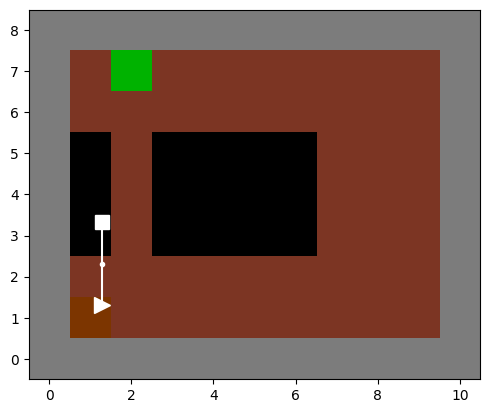

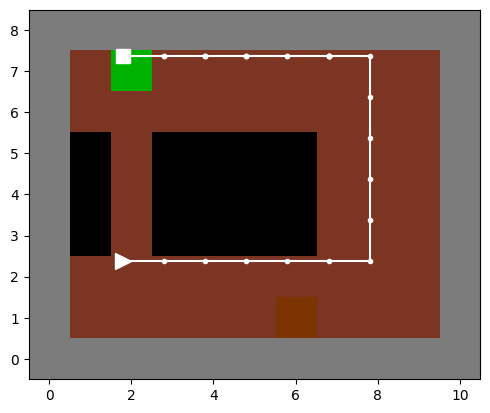

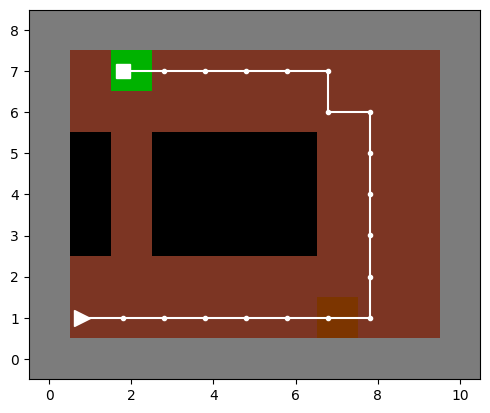

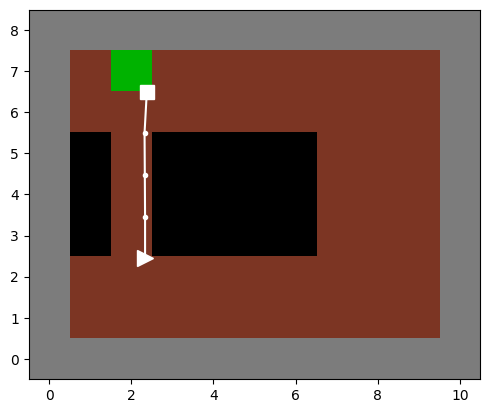

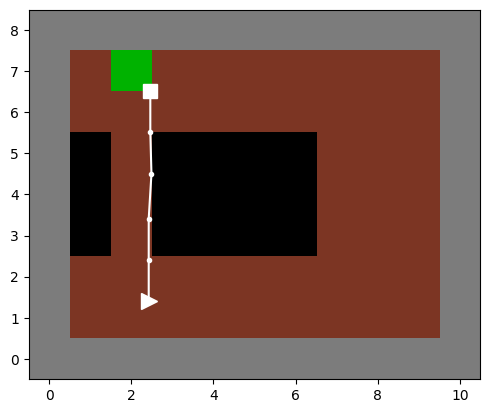

In [2]:
#Practice meta learning of Khazad-Dum

#Hyperparameters
adapt_lr =  7e-4
meta_lr = 0.0005
meta_iterations = 1250
adapt_timesteps = 32*4 #for this enviornment, each episode is exactly 32 timesteps, so multiple of 32 means full number of eps experienced for each task
tasks_per_loop = 60
adapt_visualisations = 5


vis_timesteps = meta_iterations//adapt_visualisations #denominator is number of visualisations we want
if vis_timesteps == 0:
    vis_timesteps = 1 

#Make meta-environment
import fabian.envs.khazad_dum_gymn 
env = gym.make("KhazadDum-v1") # can access wrapped env with "env.unwrapped" (e.g. to reset task)
 #^ TODO: make task resetting better than this, maybe have a meta learning wrapper for envs that provides access to these functions in a neater way

#Make meta-policy and meta-optimiser
meta_agent = A2C("MlpPolicy", env, verbose=0, meta_learning=True, learning_rate=adapt_lr, device=device) #we train the meta_agent to do well at adapting to new envs (i.e. meta learning) in our env distribution
meta_opt = optim.Adam(meta_agent.policy.parameters(), lr=meta_lr)


meta_losses = []
meta_rets = []

#Outer meta-learning loop
for meta_it in range(meta_iterations):
    meta_loss = 0
    meta_ret = 0
    #Have agent adapt to tasks one by one
    for t in tqdm(range(tasks_per_loop)):
        env.unwrapped.reset_task() #randomly selects task from environment to reset it to
        
        meta_agent.learn(total_timesteps=adapt_timesteps) #adapt the meta agent to this task

        adaptation_loss, a_rets = meta_agent.run_meta_adaption_and_loss(total_timesteps=100) #sample {total_timesteps} worth of timesteps from task and get loss of adapted agent
                #TODO: this is just for debugging - change stuff so it is just returning loss again soon! andget sepereate func for rets if needed

        meta_loss += adaptation_loss
        meta_ret += a_rets

    #Perform gradient update on meta learning parameters
    meta_loss/=tasks_per_loop #normalise, so that learning rate need not depend on tasks/loop
    meta_ret/=tasks_per_loop
    
    meta_opt.zero_grad()
    meta_loss.backward()
    meta_opt.step()

    #Track meta_training curve
    meta_losses.append(meta_loss.detach().item())
    meta_rets.append(meta_ret.item())
    print(f"Meta loop {meta_it+1}/{meta_iterations} complete, validation loss: {meta_loss.detach().item()}, validation return: {meta_ret}")

    if meta_it % vis_timesteps == 0:
        fig, ax = plt.subplots()
        ax = env.unwrapped.show_state(ax)    
        fig.show()


print(meta_losses)



[-0.12223728746175766, -0.11822440475225449, -0.12024679034948349, -0.11606548726558685, -0.12058356404304504, -0.12143557518720627, -0.11818400025367737, -0.11680390685796738, -0.11886029690504074, -0.11510400474071503, -0.11820828914642334, -0.11660981923341751, -0.1199723482131958, -0.11047417670488358, -0.1161021888256073, -0.1157727986574173, -0.11102461069822311, -0.11037767678499222, -0.11369495093822479, -0.11159735172986984, -0.10864854604005814, -0.1087530106306076, -0.11172275245189667, -0.10958155244588852, -0.10725276172161102, -0.10454616695642471, -0.10543704032897949, -0.1010662093758583, -0.10445523262023926, -0.1033034399151802, -0.10352294147014618, -0.0985107347369194, -0.10274969786405563, -0.10094259679317474, -0.09807955473661423, -0.09559805691242218, -0.09301683306694031, -0.0939125344157219, -0.0891306921839714, -0.09070542454719543, -0.08432960510253906, -0.08112148940563202, -0.08555519580841064, -0.08473392575979233, -0.08470156788825989, -0.074690476059913

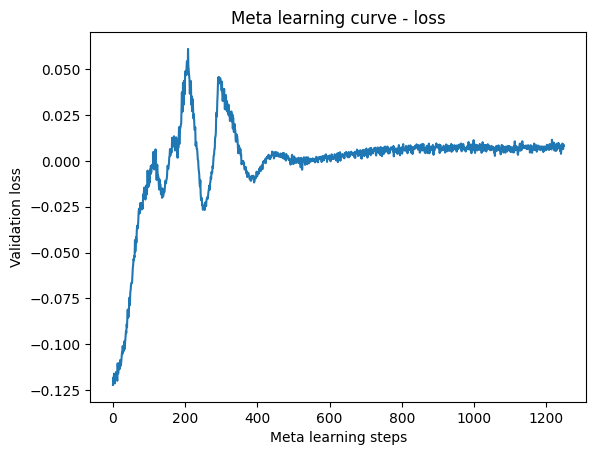

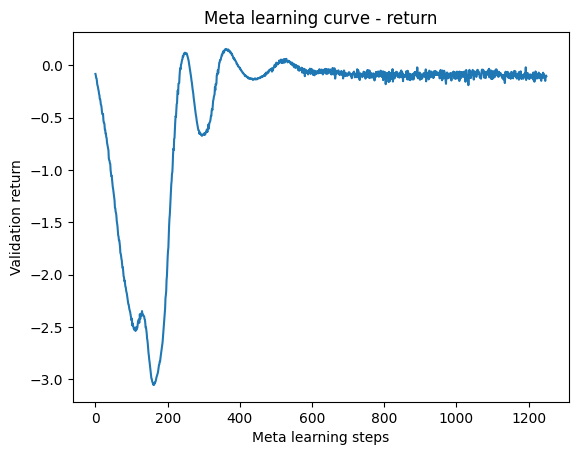

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

print(meta_losses)

# Plot meta learning curve
plt.plot(range(meta_iterations), meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve - loss')
plt.show()

# Plot meta learning curve
plt.plot(range(meta_iterations), meta_rets)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation return')
plt.title('Meta learning curve - return')
plt.show()

In [9]:
for param in meta_agent.policy.parameters():
    print(param)

Parameter containing:
tensor([[-0.0172,  0.0250,  0.2693,  ...,  0.0207,  0.2111, -0.0515],
        [-0.0199,  0.1305,  0.0386,  ...,  0.0784,  0.0104, -0.0529],
        [-0.3244, -0.2129,  0.1917,  ..., -0.0815,  0.0010,  0.0140],
        ...,
        [-0.1337, -0.2065, -0.2912,  ..., -0.1059,  0.0664, -0.0999],
        [-0.1129,  0.1758,  0.2002,  ...,  0.1458, -0.0992, -0.1078],
        [ 0.0819, -0.2280,  0.2176,  ...,  0.0872,  0.0250,  0.0005]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0295, -0.0555, -0.0476,  0.0221,  0.0117, -0.0454, -0.0088, -0.0492,
        -0.0448,  0.0166,  0.0025, -0.1058, -0.0254,  0.0036, -0.0413,  0.0326,
        -0.0082, -0.0386, -0.0088, -0.0112, -0.0128,  0.0219, -0.0046,  0.0231,
         0.0214, -0.0327, -0.0355,  0.0159,  0.0164, -0.0069,  0.0108,  0.0123,
         0.1264,  0.0256, -0.0323, -0.0074, -0.0268,  0.0015,  0.0010, -0.0933,
         0.0317, -0.0090, -0.0838,  0.0308, -0.0575,  0.0086, -0.0347, -0.0081,
         0.0355

In [10]:
print(meta_agent.policy.__dict__)

{'training': True, '_parameters': {}, '_buffers': {}, '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': {'module': ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=99,

In [ ]:
fghd

7.222222222222222

[-0.10931121557950974, -0.10973601043224335, -0.10946083068847656]


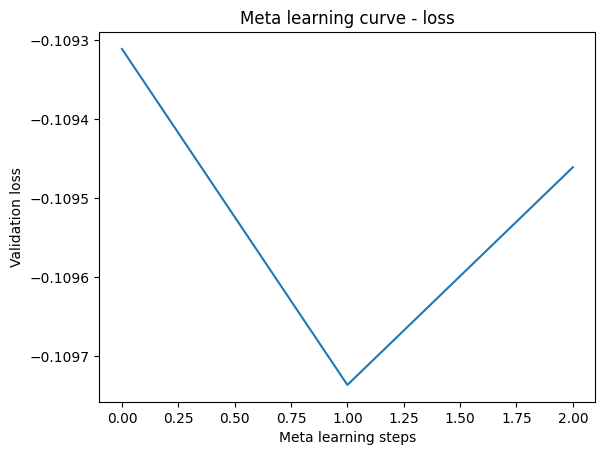

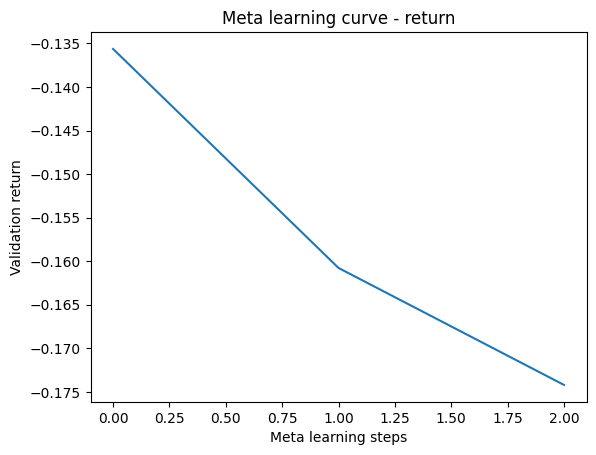

In [ ]:
#just pracitcing printing out both a loss and return curve to try and understand better if something is up

#..it seems that loss is maxminised but i want ti to be minimised. is this because the loss is somehow being flipped?
#or do i want it to be maximiised actually nad it is somehow doing that for me (wouldnt make sense why rn i think)
#... in which case hopefully i will see good things happeningt o the validation return
#or is it a bug somewhere in the way i implemented stuff?? 
# is there a tried and tested form of meta learning with a2c i can compare my implementation with - yes..(?) DO THAT
# ^^^^^ TO CHECK MY IMPLEMENTATION OF META A2C ITSELF ISNT BUGGY

import pandas as pd
import matplotlib.pyplot as plt

print(meta_losses)

# Plot meta learning curve
plt.plot(range(meta_iterations), meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve - loss')
plt.show()

# Plot meta learning curve
plt.plot(range(meta_iterations), meta_rets)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation return')
plt.title('Meta learning curve - return')
plt.show()

[tensor(-2.3634), tensor(-2.3581), tensor(-2.3724), tensor(-2.3383), tensor(-2.3100), tensor(-2.3238), tensor(-2.2619), tensor(-2.2929), tensor(-2.2870), tensor(-2.3203), tensor(-2.2867), tensor(-2.2420), tensor(-2.2615), tensor(-2.2803), tensor(-2.2726), tensor(-2.2417), tensor(-2.1978), tensor(-2.2622), tensor(-2.2530), tensor(-2.2312), tensor(-2.2875), tensor(-2.2309), tensor(-2.2130), tensor(-2.2289), tensor(-2.2308), tensor(-2.1303), tensor(-2.1072), tensor(-2.1374), tensor(-2.1046), tensor(-2.1377), tensor(-2.0508), tensor(-2.1179), tensor(-2.0495), tensor(-2.0095), tensor(-2.0366), tensor(-2.0282), tensor(-2.0077), tensor(-2.0283), tensor(-1.9611), tensor(-1.9140), tensor(-1.9551), tensor(-1.8787), tensor(-1.9205), tensor(-1.9221), tensor(-1.7510), tensor(-1.8160), tensor(-1.8093), tensor(-1.7416), tensor(-1.7470), tensor(-1.5698), tensor(-1.6090), tensor(-1.5755), tensor(-1.5618), tensor(-1.6012), tensor(-1.5213), tensor(-1.5213), tensor(-1.4766), tensor(-1.4817), tensor(-1.459

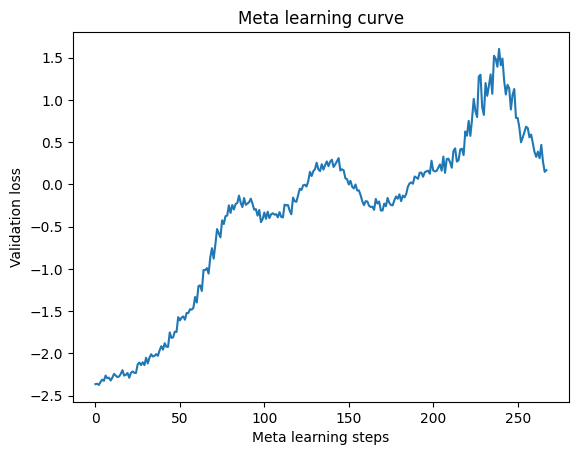

In [ ]:
"""
This was terminated early but pars are below:
#Hyperparameters
adapt_lr =  7e-4
meta_lr = 0.0005
meta_iterations = 1250
adapt_timesteps = 32*4 #for this enviornment, each episode is exactly 32 timesteps, so multiple of 32 means full number of eps experienced for each task
tasks_per_loop = 60
adapt_visualisations = 5
"""

import pandas as pd
import matplotlib.pyplot as plt

print(meta_losses)

# Plot meta learning curve
plt.plot(range(268), meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve')
plt.show()

[-2.5227878093719482, -2.516270160675049, -2.4697821140289307, -2.4945788383483887, -2.5105323791503906, -2.4764833450317383, -2.4443984031677246, -2.4746501445770264, -2.3993544578552246, -2.447183132171631, -2.459886074066162, -2.433267831802368, -2.5069284439086914, -2.5048887729644775, -2.5258991718292236, -2.4208741188049316, -2.433600425720215, -2.504063844680786, -2.4767937660217285, -2.4344611167907715, -2.3959105014801025, -2.3895764350891113, -2.4595823287963867, -2.456427574157715, -2.5198545455932617, -2.3960912227630615, -2.3945119380950928, -2.4351351261138916, -2.3902385234832764, -2.398770809173584, -2.4308125972747803, -2.4799885749816895, -2.472285032272339, -2.4636428356170654, -2.4132895469665527, -2.337040662765503, -2.4070119857788086, -2.384591817855835, -2.4676334857940674, -2.4688830375671387, -2.399146556854248, -2.3972394466400146, -2.394533634185791, -2.39324688911438, -2.3637983798980713, -2.349691152572632, -2.4135630130767822, -2.3438336849212646, -2.3628

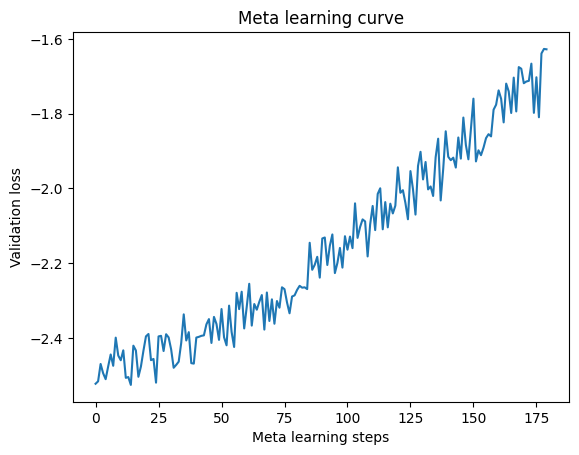

In [ ]:
"""
adapt_lr =  7e-4
meta_lr = 0.0001
meta_iterations = 180
adapt_timesteps = 32*4 #for this enviornment, each episode is exactly 32 timesteps, so multiple of 32 means full number of eps experienced for each task
tasks_per_loop = 60
"""

#hmm i really am not sure what is going on here because it seems to be very confidently increasing, not decreasing loss.
#I will try with learning rate 0.005 (to be a bit smaller as this smaller learning rate does seem a bit smoother - but maybe thats cause...
# ...its only the start of the curve ), and an absolute ton of iterations (1250) - this run tok 1hr so the other one should take me just around 7hrs


import pandas as pd
import matplotlib.pyplot as plt

print(meta_losses)

# Plot meta learning curve
plt.plot(range(meta_iterations), meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve')
plt.show()

[-1.8884780406951904, -1.9937653541564941, -2.018599510192871, -1.9692550897598267, -1.9187734127044678, -1.9575958251953125, -1.9529651403427124, -2.0065762996673584, -1.980093002319336, -1.9015858173370361, -1.893201231956482, -1.8855994939804077, -1.909571886062622, -1.8483508825302124, -1.7716147899627686, -1.7736968994140625, -1.7430089712142944, -1.736778736114502, -1.76603102684021, -1.5698304176330566, -1.420850396156311, -1.4866851568222046, -1.4655964374542236, -1.4639966487884521, -1.3706929683685303, -1.2777316570281982, -1.2740353345870972, -0.9754828214645386, -1.0826343297958374, -1.1299182176589966, -0.9913367629051208, -0.9502995610237122, -0.867975115776062, -0.7627165913581848, -0.859039843082428, -0.765615701675415, -0.8887611031532288, -0.6826343536376953, -0.7002241015434265, -0.6528527736663818, -0.5830522179603577, -0.7034017443656921, -0.6260512471199036, -0.4900871217250824, -0.5224405527114868, -0.5975875854492188, -0.43971332907676697, -0.4475315511226654, -

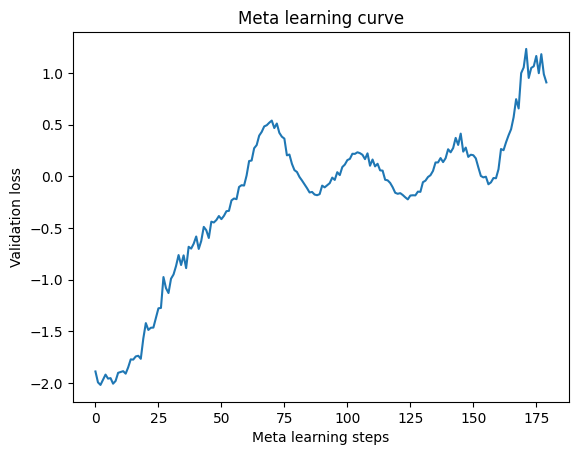

In [ ]:
"""
adapt_lr =  7e-4
meta_lr = 0.001
meta_iterations = 180
adapt_timesteps = 32*4 #for this enviornment, each episode is exactly 32 timesteps, so multiple of 32 means full number of eps experienced for each task
tasks_per_loop = 60
"""

#even with many fewer adaptation timesteps it looks like its optimising in the wrong direction which is so wierd 
#though with fewer adaptiation timesteps it is actually optimising *better* in the wrong direction - it is getting the loss up to 1...
#the problem is, i want the loss to be low right?


import pandas as pd
import matplotlib.pyplot as plt

print(meta_losses)

# Plot meta learning curve
plt.plot(range(meta_iterations), meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve')
plt.show()

[-2.0492193698883057, -2.1788887977600098, -2.086446523666382, -2.1013951301574707, -2.1142704486846924, -2.210110664367676, -2.2031919956207275, -2.211686372756958, -2.190762996673584, -2.2015345096588135, -2.1775994300842285, -2.195617198944092, -2.2229695320129395, -2.193450450897217, -2.128512144088745, -2.1572840213775635, -2.179680585861206, -2.111292839050293, -1.94134521484375, -2.1051156520843506, -2.0802152156829834, -1.9851154088974, -1.9037370681762695, -1.8435249328613281, -1.8489757776260376, -1.8947416543960571, -1.8825962543487549, -1.6654469966888428, -1.7023357152938843, -1.607826828956604, -1.5253666639328003, -1.5043814182281494, -1.3357595205307007, -1.3351120948791504, -1.186092734336853, -1.1444802284240723, -0.9721044301986694, -1.0818504095077515, -1.0099844932556152, -0.7326979637145996, -0.6951233148574829, -0.7511599063873291, -0.5665568113327026, -0.2993660271167755, -0.3716145157814026, -0.20345337688922882, -0.24065837264060974, -0.20189854502677917, -0.2

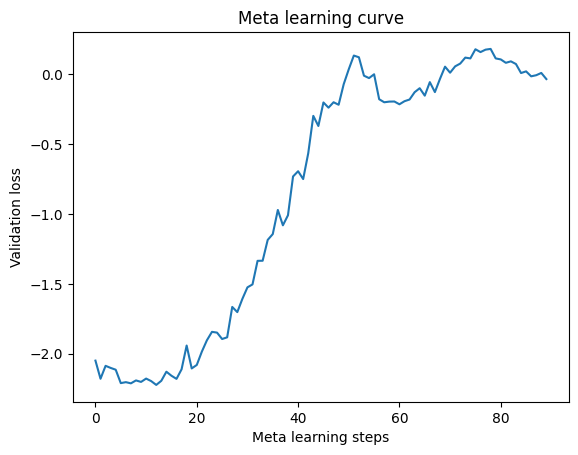

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

print(meta_losses)

# Plot meta learning curve
plt.plot(range(meta_iterations), meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve')
plt.show()

In [ ]:
efdgfds

[-2.1880381107330322, -2.083814859390259, -2.066087245941162, -2.216740608215332, -2.1172308921813965, -2.092665910720825, -2.1657261848449707, -2.1747829914093018, -2.039454936981201, -2.1051766872406006, -2.1004040241241455, -2.021328926086426, -2.0316922664642334, -2.031277656555176, -1.954834222793579, -1.9632339477539062, -1.8973366022109985, -1.917079210281372, -1.826287031173706, -1.6213903427124023, -1.601932168006897, -1.6621402502059937, -1.5202207565307617, -1.4991427659988403, -1.4450041055679321, -1.4442946910858154, -1.3697489500045776, -1.339324712753296, -1.2190417051315308, -1.2881228923797607, -1.1535401344299316, -1.1118284463882446, -1.0954128503799438, -1.075300931930542, -1.07248854637146, -1.0811342000961304, -1.0319054126739502, -0.9143872261047363, -0.7963337898254395, -0.9751865267753601, -0.9282328486442566, -0.8169077038764954, -0.9631141424179077, -0.815366268157959, -0.8149248361587524, -0.977098286151886, -0.8127043843269348, -0.8622453808784485, -0.86119

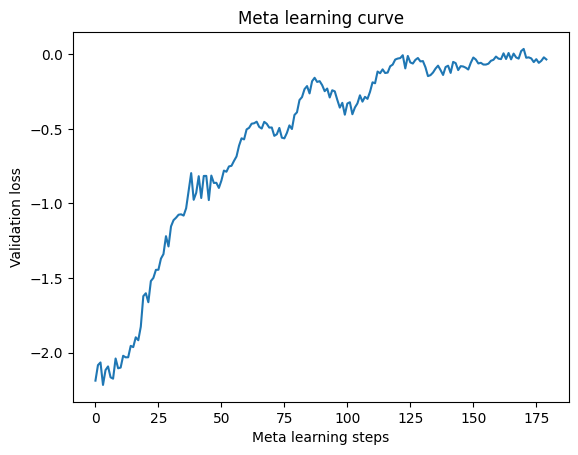

In [ ]:
"""
KD meta learning with the following hyperparameters:
#Hyperparameters
adapt_lr =  7e-4
meta_lr = 0.001
meta_iterations = 180
adapt_timesteps = 32*60 #for this enviornment, each episode is exactly 32 timesteps, so multiple of 32 means full number of eps experienced for each task
tasks_per_loop = 40
"""

#wierdly, it looks very much like the meta learning is increasing the loss function, not decreasing it - assuming all my graidnets have the right
#... signs and all that is OK, i presume this means that my step size is too big? Or in fact my adaptation is too long so that the gradients are too noisy by the 
#... time the graident makes it all the way back to the start.
#Given the meta learning rate is 0.001, which is the learning rate they use in the learn2learn mujoco dice example, i will first try with ...
#...a smaller length of adaptation (going WAYY smaller and closer to one-shot adaptation, with 4 episodes for each adaptation)
#It could also be that because it needs to train for a bunch of tasks perhaps it just needs to train for longer to be able to generalise well to them all?

import pandas as pd
import matplotlib.pyplot as plt

print(meta_losses)

# Plot meta learning curve
plt.plot(range(meta_iterations), meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve')
plt.show()

In [8]:
werth

NameError: name 'werth' is not defined

Output()

c:\Users\fabia\anaconda3\envs\learn2learn_newtorch\Lib\site-packages\gymnasium\envs\registration.py:487: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
C:\Users\fabia\Documents\Uni\Part C\CS Project\Code\learn2learn-master\learn2learn-master\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


c:\Users\fabia\Documents\Uni\Part C\CS 
Project\Code\learn2learn-master\learn2learn-master\fabian\envs\khazad_dum_gymn.py:434: UserWarning: FigureCanvasAgg
is non-interactive, and thus cannot be shown
  fig.show()

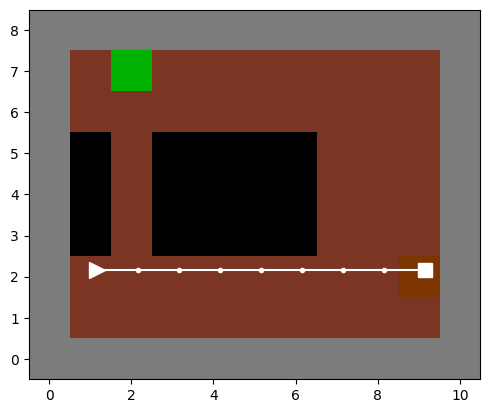

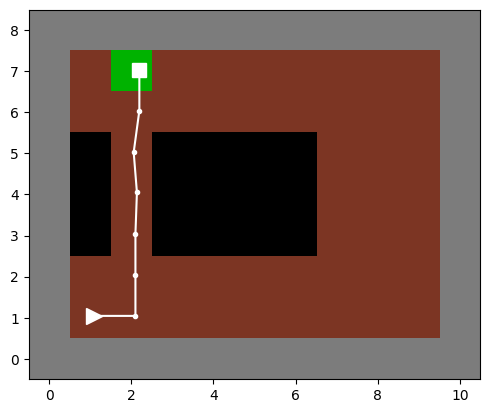

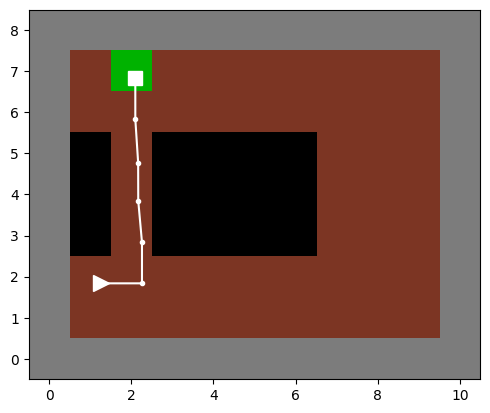

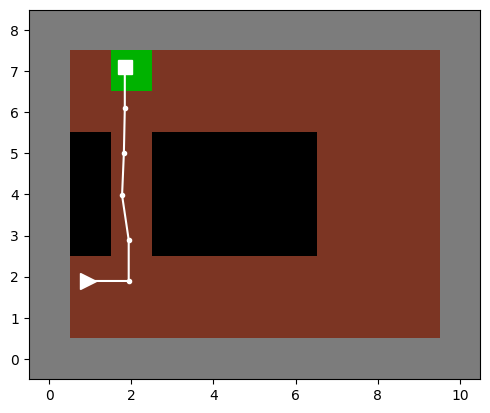

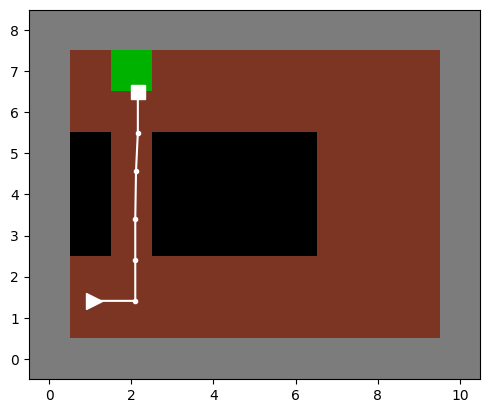

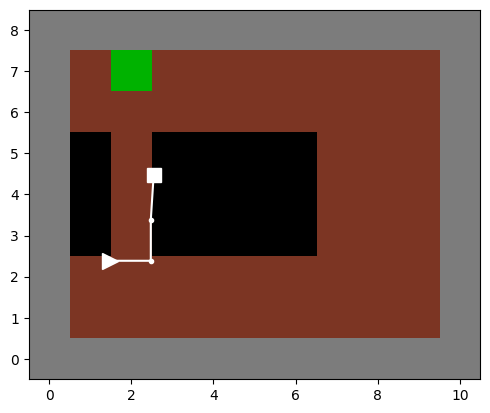

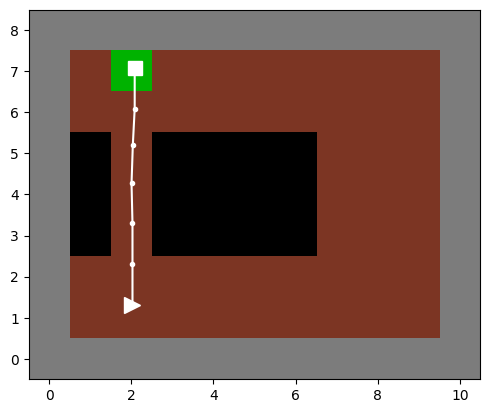

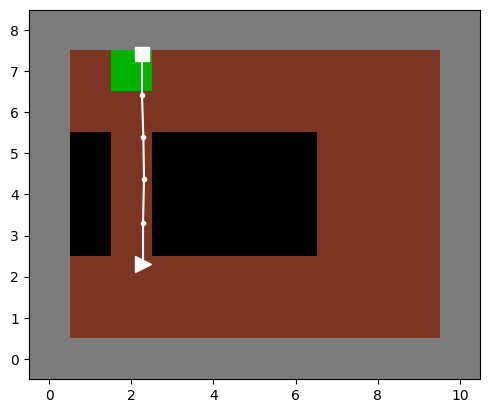

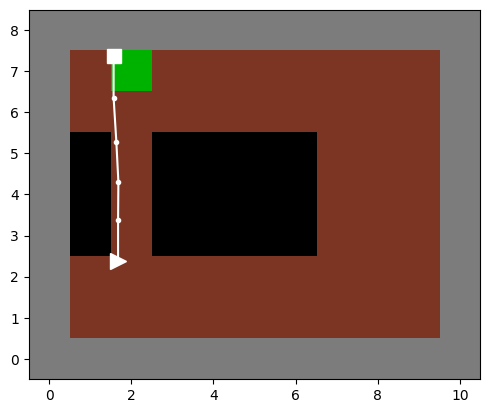

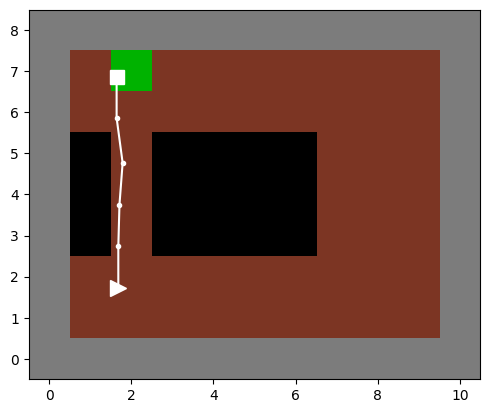

In [ ]:
log_file = "train_logs/kd_t1"

#TODO: i need something to test against verification each X iterations and save the best model aainst veriifcation set

#Doing standard training with Khazad-Dum to check I can (then will upgrade to meta-learning)
import fabian.envs.khazad_dum_gymn 
env = gym.make("KhazadDum-v1", plot_interval = 100_000)

model = A2C("MlpPolicy", env, verbose=0, meta_learning=False)
logger = configure(log_file, ["csv", "tensorboard"])
model.set_logger(logger) #adds a logger to track progress training
model.learn(total_timesteps=1_000_000, progress_bar=True) #it seems that just the standard learning rate with lots of iterations does well!! good :)




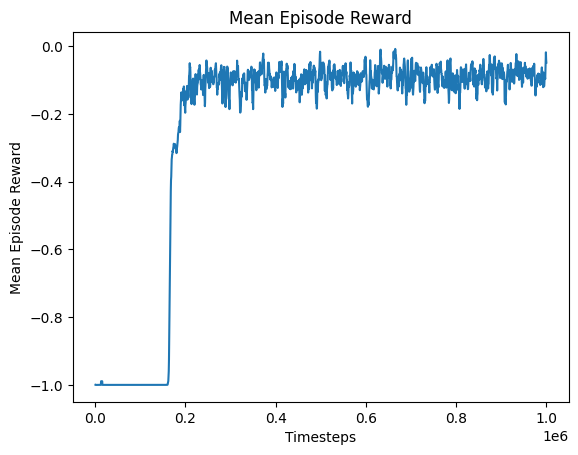

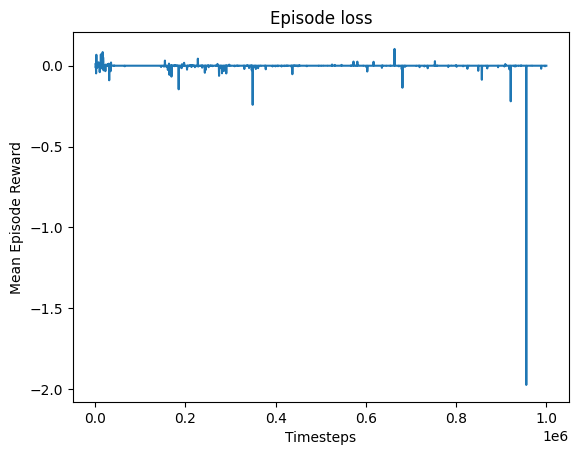

In [9]:

import pandas as pd
import matplotlib.pyplot as plt


# Load training logs
data = pd.read_csv(f"{log_file}/progress.csv")

# Plot rewards
plt.plot(data['time/total_timesteps'], data['rollout/ep_rew_mean'])
plt.xlabel('Timesteps')
plt.ylabel('Mean Episode Reward')
plt.title('Mean Episode Reward')
plt.show()

# Plot rewards
plt.plot(data['time/total_timesteps'], data['train/policy_loss'])
plt.xlabel('Timesteps')
plt.ylabel('Mean Episode Reward')
plt.title('Episode loss')
plt.show()

In [ ]:
#Quick check that sb3 is working OK when i set it on meta learning including trying to get a meta-gradinet
import gymnasium as gym

from stable_baselines3 import A2C

from stable_baselines3.common.logger import configure

env = gym.make("HalfCheetah-v5", render_mode="rgb_array")


model = A2C("MlpPolicy", env, verbose=0, meta_learning=True, learning_rate=1) #learning rate here is the adaptation learning rate
    #I think i need to look at how A2C (and in general, sb3 models) are defined because i need it to match the maml definition



meta_opt = optim.Adam(model.policy.parameters(), lr=0.1) #Use Adam for optimising meta-policy's parameters (with updates according to {meta_lr})


param_index = 6 #index of parametrers to output to sanity check training

#print old meta params
print([param for param in model.policy.parameters()][param_index])



logger = configure("train_logs/", ["csv", "tensorboard"])
model.set_logger(logger) #adds a logger to track progress training

model.learn(total_timesteps=3)#_000)
#print adapted policy's trained params
print([param for param in model.policy_clone.parameters()][param_index])

adaptation_loss = model.run_meta_adaption_and_loss(total_timesteps=100) #sample {total_timesteps} worth of timesteps from environment and get loss 
print(adaptation_loss)


#print meta policy's poarmas before meta optimisation (should be unchanged from what they were intiially)
print([param for param in model.policy.parameters()][param_index])

meta_opt.zero_grad()
adaptation_loss.backward()
meta_opt.step()

#print new meta params
print([param for param in model.policy.parameters()][param_index])



using fabians a2c
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
tensor([-7.0171e-03,  1.1375e-01,  4.5612e-03,  1.1615e-02, -6.1680e-02,
         4.7324e-02,  2.4447e-02, -8.2521e-03,  2.1579e-03, -4.1334e-02,
        -3.3524e-04, -2.3113e-02,  6.2922e-03,  4.0085e-02, -1.4020e-02,
        -8.1416e-02, -3.1014e-02, -3.7969e-02,  7.1486e-03,  3.4022e-02,
         3.5291e-02, -9.1399e-05,  3.2315e-02, -4.7263e-02, -5.5050e-02,
        -3.8856e-02, -1.9487e-02, -4.5429e-02,  1.1100e-02,  2.9423e-02,
        -3.7895e-03,  4.8110e-02,  1.2357e-02,  6.9032e-03,  9.2679e-03,
        -2.5754e-03,  1.5857e-02, -1.6140e-02, -5.5344e-03, -1.7921e-02,
         2.9229e-02, -4.0560e-03,  3.9136e-02,  2.1

C:\Users\fabia\Documents\Uni\Part C\CS Project\Code\learn2learn-master\learn2learn-master\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


tensor(43.3974, device='cuda:0', grad_fn=<AddBackward0>)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,  0.1000,
         0.1000, -0.1000,  0.1000,  0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,  0.1000,
         0.1000, -0.1000, -0.1000,  0.1000, -0.1000, -0.1000,  0.1000,  0.1000,
         0.1000, -0.1000, -0.1000, -0.1000,  0.1000,  0.1000,  0.1000, -0.1000,
         0.1000, -0.1000, -0.1000, -0.1000, -0.1000,  0.1000,  0.1000,  0.1000,
        -0.1000,  0.1000, -0.1000,  0.1000, -0.1000,  0.1000,  0.1000,  0.1000,
        -0.100

using fabians a2c


C:\Users\fabia\Documents\Uni\Part C\CS Project\Code\learn2learn-master\learn2learn-master\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


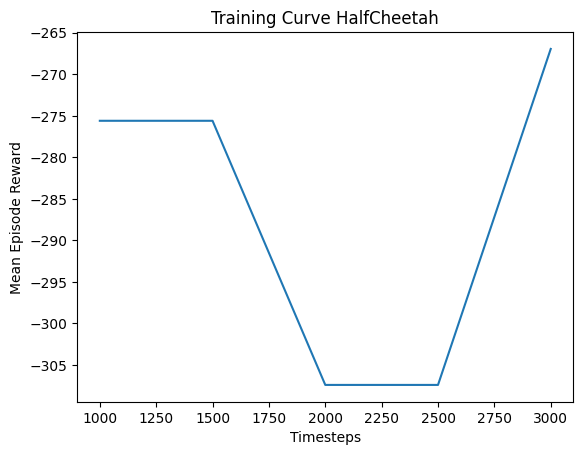

In [ ]:
#Quick check that sb3 is working OK when i set it on meta learning (and then the next step is to try and take a gradient)
import gymnasium as gym

from stable_baselines3 import A2C

from stable_baselines3.common.logger import configure

env = gym.make("HalfCheetah-v5", render_mode="rgb_array")



model = A2C("MlpPolicy", env, verbose=0, meta_learning=True)
    #I think i need to look at how A2C (and in general, sb3 models) are defined because i need it to match the maml definition

logger = configure("train_logs/", ["csv", "tensorboard"])
model.set_logger(logger) #adds a logger to track progress training

model.learn(total_timesteps=3_000)#_000)




vec_env = model.get_env()
obs = vec_env.reset()

for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    #vec_env.render("human")
    # VecEnv resets automatically
    # if done:
    #   obs = vec_env.reset()


import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
data = pd.read_csv("train_logs/progress.csv")

# Plot rewards
plt.plot(data['time/total_timesteps'], data['rollout/ep_rew_mean'])
plt.xlabel('Timesteps')
plt.ylabel('Mean Episode Reward')
plt.title('Training Curve HalfCheetah')
plt.show()

using fabians a2c


C:\Users\fabia\Documents\Uni\Part C\CS Project\Code\learn2learn-master\learn2learn-master\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


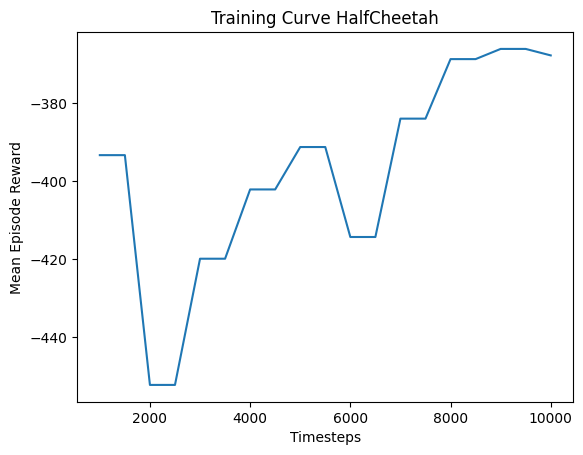

In [ ]:
#Quick check that sb3 is working OK
import gymnasium as gym

from stable_baselines3 import A2C

from stable_baselines3.common.logger import configure

env = gym.make("HalfCheetah-v5", render_mode="rgb_array")



model = A2C("MlpPolicy", env, verbose=0)
    #I think i need to look at how A2C (and in general, sb3 models) are defined because i need it to match the maml definition

logger = configure("train_logs/", ["csv", "tensorboard"])
model.set_logger(logger) #adds a logger to track progress training

model.learn(total_timesteps=10_000)




vec_env = model.get_env()
obs = vec_env.reset()

for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    #vec_env.render("human")
    # VecEnv resets automatically
    # if done:
    #   obs = vec_env.reset()


import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
data = pd.read_csv("train_logs/progress.csv")

# Plot rewards
plt.plot(data['time/total_timesteps'], data['rollout/ep_rew_mean'])
plt.xlabel('Timesteps')
plt.ylabel('Mean Episode Reward')
plt.title('Training Curve HalfCheetah')
plt.show()

In [ ]:

    
#the tricky thing is, the maml object is designed to encapsulate a nn.module object, and allow us to (1) pass things through it and (2) update
#... its gradients when a loss is passed to it - in a way which lets us then MAML optimise over hte whole thing

#But sb3 encapsulates the policy (which does have nn.module as a grandparent) within the overall agent - while the agent is not a nn.module.

#I dont want to be fiddling too much with sb3 itself, i really want something more plug-and-play-like
#Can I perhaps instnatiate a sb3 policy, and wrap it in MAML?
"""
    -> I *can* pass a custom policy into a SB3 agent, by setting policy=x where x:BasePolicy
    -> So the question becomes, is the policy used in the agent in a way where i can get it to do the desired maml updates
    -> perhaps i can take a SB3 policy, make a MAML_Policy class to pass it into a cosntructor for, where gradient updates use the MAML graident update?
    -> or even have it as a sort of template class that any policy can tehn be made a parent class of (if poss in python?) so that methods just transfer down and i can override what i want?
        ^ i could, i suppose, do this with a function by passing in an instance of a class and then overrideing its class functions as desired in the decorateor?

    -> I am a little less hopeful now.. within sb3 the way it trains the policy is suing an optimiser defined within the policy, defining a loss
    ... quantity, doing loss.backward() and then policy.optimiser.step()
        ^so maybe the thing to do is, in the end, get a local version of sb3 going here and adjusting it so that the a2c modle (and others) use a function within the policy to learn
         if the function exists, and if it doesnt do the stnadard thing

    PLAN: i think the plan is to change the implementation of SB3 agents s.t. theri constructor has a parameeter ('meta_learn')
    which if false all stays as it is, but if true then the policy gets passed through MAML and when the agent is trained, it is trained
    through MAML to then be able to take the gradinet of any function (i..e validation loss) of this policy w.r.t initial parameters

    Then we need a clone function for these SB3 agents (if not one alreqady) which clones the policy, so that we can have a fresh agent, with a fresh
    enviornment, for each meta learning loop

    then ideally there should be a function that, in the spirit of SB3, can do meta learning vien a env generator as a function of a meta env?

    """





In [ ]:
#Trying to join together the MAML meta learning loop with the way sb3 works

theta = ... #store the parameters of our meta model
meta_env = ... #a class which is a 'meta environentn'; from which we can sample gymnasium environments

#Meta learning (outer) loop
for iteration in range(num_iterations):
    iteration_loss = 0.0
    iteration_reward = 0.0

    #Sample one task (environment) at a time
    for env in tqdm(meta_env.sample(num_tasks_to_sample)): 
        
        #Set up our agent to be adapted, with its parameters starting as desired
        adapt_model = A2C("MlpPolicy", env, verbose=0) #swap A2C and MlpPolicy out with whatever is appropriate
        adapt_model.pars = theta.clone()

        learner = meta_learner.clone()
        env.set_task(task_config)
        env.reset()
        task = ch.envs.Runner(env)

        # Fast Adapt
        for step in range(adapt_steps):
            train_episodes = task.run(learner, episodes=adapt_bsz) #run {adapt_bsz} episodes from each task; these are the episodes against which erach gradient step (adapting the agent to the task) is performed
            loss = maml_a2c_loss(train_episodes, learner, baseline, gamma, tau)
            learner.adapt(loss)

        # Compute Validation Loss - estimating the loss of each adapted policy against the task for which it was adapted, by each adapted policy against {adapt_bsz} episodes from its task
        valid_episodes = task.run(learner, episodes=adapt_bsz)
        loss = maml_a2c_loss(valid_episodes, learner, baseline, gamma, tau) 
        iteration_loss += loss
        iteration_reward += valid_episodes.reward().sum().item() / adapt_bsz


    opt.zero_grad()
    adaptation_loss.backward()
    opt.step()

using fabians a2c


C:\Users\fabia\Documents\Uni\Part C\CS Project\Code\learn2learn-master\learn2learn-master\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


TypeError: MAML.__init__() missing 1 required positional argument: 'lr'

In [ ]:
#Quick check that sb3 is working OK
import gymnasium as gym

from stable_baselines3 import A2C

from stable_baselines3.common.logger import configure

env = gym.make("HalfCheetah-v5", render_mode="rgb_array")



model = A2C("MlpPolicy", env, verbose=0)
    #I think i need to look at how A2C (and in general, sb3 models) are defined because i need it to match the maml definition

logger = configure("train_logs/", ["csv", "tensorboard"])
model.set_logger(logger) #adds a logger to track progress training

model.learn(total_timesteps=10_000)




vec_env = model.get_env()
obs = vec_env.reset()

for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    #vec_env.render("human")
    # VecEnv resets automatically
    # if done:
    #   obs = vec_env.reset()


import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
data = pd.read_csv("train_logs/progress.csv")

# Plot rewards
plt.plot(data['time/total_timesteps'], data['rollout/ep_rew_mean'])
plt.xlabel('Timesteps')
plt.ylabel('Mean Episode Reward')
plt.title('Training Curve HalfCheetah')
plt.show()

using fabians a2c


C:\Users\fabia\Documents\Uni\Part C\CS Project\Code\learn2learn-master\learn2learn-master\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


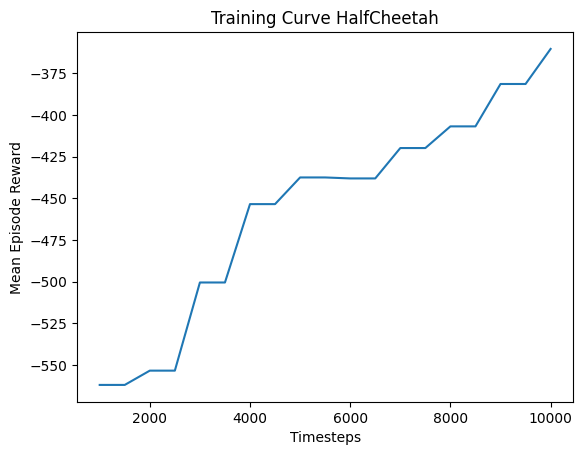

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
data = pd.read_csv("train_logs/progress.csv")

# Plot rewards
plt.plot(data['time/total_timesteps'], data['rollout/ep_rew_mean'])
plt.xlabel('Timesteps')
plt.ylabel('Mean Episode Reward')
plt.title('Training Curve HalfCheetah')
plt.show()